# Fit a REML GAM as a REML GLMM with MixedEffects.jl

In [1]:
# largest farms = farms with samples from more than 50 cows in 2023

In [1]:
library(tictoc)

In [2]:
tic()
suppressPackageStartupMessages({
    library(gamm4)
    library(arrow)
    library(dplyr)
    library(arrow)
    library(gratia)
    library(base64enc)
    library(jsonlite)
    library(reticulate)
    library(mgcViz)
    library(MASS)
    library(itsadug)
})
toc()

run_and_fetch_stdout <- function(exec_cmd) {
  # Open the pipe to the specified command
  output_pipe <- pipe(exec_cmd, open = "r")
  
  while(TRUE) {
    # Attempt to read a line from the output pipe
    line <- readLines(output_pipe, n = 1, warn = FALSE)
    
    # Check if no more lines are available (indicates script has finished)
    if (length(line) == 0) break
    
    # Process the output (can be delayed or sporadic)
    cat(line, "\n")
  }
  
  # Close the pipe when the script ends
  close(output_pipe)
}

read_json <- function(json_fpath) {
    con <- file(json_fpath, "r")
    json_data <- stream_in(con)
    close(con)
    return(json_data)
}

1.028 sec elapsed


In [3]:
experiment_name <- "gammJ_devel-R-subsample-v9_HO_milk_before_2010"
model_fname <- paste0(experiment_name, "_gam_model.RData")
plot_fname <- paste0(experiment_name, "_gam_plot_data.RData")
julia_fname <- paste0(experiment_name, "_gam_julia_data.json")

In [5]:
tic()

In [6]:
set.seed(2024)

In [7]:
tic()
data <- read_parquet("/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/31_base_data_september_HO.parquet")
toc()

25.602 sec elapsed


In [8]:
data <- data[data$year <= 2010,]

In [9]:
data$year <- as.factor(data$year)

In [10]:
data <- droplevels(data)

In [11]:
sample_farms_until_threshold <- function(dataframe, threshold) {
  # Get all unique farm IDs and shuffle the list of unique farms
  unique_farms <- unique(dataframe$farmIdLocationSample)
  shuffled_farms <- sample(unique_farms)  # This shuffles the unique farm IDs
  
  # Initialize variables to track the total samples and selected farm IDs
  total_samples <- 0
  selected_farms <- vector("character", length(unique_farms))  # Store selected farm IDs
  index <- 1
  
  # Sample farms until we reach the threshold
  for (farm_id in shuffled_farms) {
    # Get the number of samples for the current farm
    num_samples <- sum(dataframe$farmIdLocationSample == farm_id)
    
    # Add the samples count to the total
    total_samples <- total_samples + num_samples
    
    # Store the farm ID
    selected_farms[index] <- farm_id
    index <- index + 1
    
    # Check if the total samples have reached or exceeded the threshold
    if (total_samples >= threshold) {
      break
    }
  }
  
  # Subset the dataframe to include only the selected farms
  selected_samples <- subset(dataframe, farmIdLocationSample %in% selected_farms[1:(index - 1)])
  
  # Return the resulting dataframe with selected samples
  return(selected_samples)
}

In [12]:
tic()
df_subsample <- sample_farms_until_threshold(data, 1000000)
#df_subsample <- data
rm(data)
toc()

79.882 sec elapsed


In [13]:
tic()
df_subsample <- droplevels(df_subsample)
toc()

0.464 sec elapsed


In [14]:
nrow(df_subsample)

[1] 1001308

In [15]:
tic()

In [16]:
gamm4_formula = milk ~ 1 + s(thi_mean_t0_3d, by=parity) + s(days_in_milk_t, by=parity, k=16) + parity + year
gamm4_random= ~((1 | zip_month) + (1 | farmIdLocationSample) + (1 | animalId))
gamm4_family=gaussian()
gamm4_data=df_subsample
gamm4_weights=NULL
gamm4_subset=NULL
gamm4_knots=NULL
gamm4_drop.unused.levels=TRUE
gamm4_REML=TRUE
gamm4_control=lmerControl(calc.derivs = FALSE, optimizer = "bobyqa", optCtrl = list())
gamm4_start=NULL
gamm4_verbose=10

In [17]:
# Extract variable names of random effects
if (!is.null(gamm4_random)) {
    if (!inherits(gamm4_random,"formula")) stop("gamm4 requires `random' to be a formula")
    random.vars <- all.vars(gamm4_random)
  } else random.vars <- NULL

In [18]:
random.vars

[1] "zip_month"            "farmIdLocationSample" "animalId"

In [19]:
# create model frame.....
# this takes the model formula interpetes the smooth part and splits it from the pure parametric part. the parametric parts will be first, followed by the smooths
gam_params <- interpret.gam(gamm4_formula) 

In [20]:
gam_model_frame <- model.frame(formula=gam_params$fake.formula,
                           data=gamm4_data,
                           REML=NULL,
                           verbose=NULL,
                           control=NULL,,
                           start=NULL,
                           family=NULL,
                           scale=NULL,
                           knots=NULL,
                           random=NULL,
                           drop.unused.levels=gamm4_drop.unused.levels)

In [21]:
gam.terms <- attr(gam_model_frame,"terms") # terms object for `gam' part of fit -- need this for prediction to work properly

In [22]:
tic()
# checks if model has random effects
if (length(random.vars)) {
    # create model frame for the mixed effects model - but only if there are random effects
    model_formula <- as.formula(paste(paste(deparse(gam_params$fake.formula, backtick = TRUE), collapse = ""), "+", paste(random.vars, collapse = "+")))
    print(model_formula)
    lmm_model_frame <- model.frame(formula=model_formula,
                           data=gamm4_data,
                           REML=NULL,
                           verbose=NULL,
                           control=NULL,,
                           start=NULL,
                           family=NULL,
                           scale=NULL,
                           knots=NULL,
                           random=NULL,
                           drop.unused.levels=gamm4_drop.unused.levels)
} else lmm_model_frame <- gam_model_frame
rm(gam_model_frame)

# check the number of datapoints
if (nrow(lmm_model_frame)<2) {
    stop("Not enough (non-NA) data to do anything meaningful")
    }
toc()

milk ~ parity + year + thi_mean_t0_3d + parity + days_in_milk_t + 
    parity + zip_month + farmIdLocationSample + animalId
0.248 sec elapsed


In [23]:
# create variable summary for the mgcv library
tic()
vars <- all.vars(gam_params$fake.formula[-2]) ## drop dependent variable (y) here
dl = as.list(gamm4_data[,vars])
var.summary <- mgcv:::variable.summary(gam_params$pf,dl,nrow(lmm_model_frame)) ## summarize the input data
rm(dl)
toc()

0.097 sec elapsed


In [24]:
#mvars <- vars[!vars%in%names(lmm_model_frame)] ## variables not in mf raw -- can cause lmer problem
#if (length(mvars)>0) for (i in 1:length(mvars)) mf[[mvars[i]]] <- dl[[mvars[i]]] ## append raw versions to mf

In [25]:
# Fixed Effect model frame without the smooth terms and random effects
tic()
pmf <- model.frame(formula=gam_params$pf,
                           data=gamm4_data,
                           REML=NULL,
                           verbose=NULL,
                           control=NULL,
                           start=NULL,
                           family=NULL,
                           scale=NULL,
                           knots=NULL,
                           random=NULL,
                           drop.unused.levels=gamm4_drop.unused.levels)
toc()

0.098 sec elapsed


In [26]:
gam_params$pf

milk ~ parity + year

In [27]:
p_terms <- attr(pmf,"terms")

In [28]:
# Decision LMM or GLMM
if (is.character(gamm4_family)) gamm4_family<-eval(parse(text=family))
if (is.function(gamm4_family)) gamm4_family <- family()
if (is.null(gamm4_family$family)) stop("family not recognized")
if (gamm4_family$family == "gaussian" && gamm4_family$link == "identity") is_lmm <- TRUE else is_lmm <- FALSE

In [29]:
is_lmm

[1] TRUE

# Prepare matrices for smooth terms

In [30]:
tic()
G <- mgcv:::gam.setup(gam_params,p_terms,
                 data=lmm_model_frame,knots=gamm4_knots,sp=NULL, min.sp=NULL,H=NULL,absorb.cons=TRUE,sparse.cons=0,gamm.call=TRUE)
toc()

13.294 sec elapsed


In [31]:
names(G)

[1] "m"             "min.sp"        "pearson.extra" "dev.extra"    
 [5] "n.true"        "pterms"        "intercept"     "nsdf"         
 [9] "contrasts"     "xlevels"       "assign"        "smooth"       
[13] "S"             "off"           "cmX"           "X"            
[17] "sp"            "rank"          "n.paraPen"     "lsp0"         
[21] "y"             "n"             "w"             "term.names"

In [32]:
if (!is.null(G$L)) {
    stop("gammJ can not handle linked smoothing parameters (probably from use of `id' or adaptive smooths)")
}

In [33]:
first.f.para <- G$nsdf+1 # number of parametric, non-smooth, model terms including the intercept + 1

random_effects <- list()

# create index selector for all fixed effect terms including the incercept in the G$X matrix (this does not include the fixed effect terms generated for the smooth)
if (G$nsdf>0) {
    ind <- 1:G$nsdf
} else {
    ind <- rep(0,0)
}

# create sparse fixed effect matrix with the index selector created above
X <- G$X[,ind,drop=FALSE] # accumulate fixed effects into here
xlab <- rep("",0)
G$Xf <- as(X,"dgCMatrix") ## sparse version of full matrix, treating smooths as fixed

first.para <- G$nsdf+1

used.names <- names(lmm_model_frame) ## keep track of all variable names already used

In [34]:
names(G$smooth[[1]])

[1] "term"           "bs.dim"         "fixed"          "dim"           
 [5] "p.order"        "by"             "label"          "xt"            
 [9] "id"             "sp"             "drop.null"      "S"             
[13] "UZ"             "Xu"             "df"             "shift"         
[17] "rank"           "null.space.dim" "plot.me"        "side.constrain"
[21] "repara"         "S.scale"        "by.level"       "vn"            
[25] "first.para"     "last.para"      "first.sp"       "last.sp"

In [35]:
tic()
## work through the smooths (G$m is the number of smooth terms)
## sm stands for smooth term
if (G$m) for (i in 1:G$m) {
    
    # get the parameters for smooth
    sm <- G$smooth[[i]] 

    # get corresponding column indexed for the fixed effect matrix
    sm_fixed_start_idx <- sm$first.para
    sm_fixed_stop_idx <- sm$last.para

    # create sparse matrix X in smooth term with the corresponding fixed effect matrix columns
    sm$X <- G$X[,sm_fixed_start_idx:sm_fixed_stop_idx,drop=FALSE]

    ## convert smooth to random effect and fixed effects (mixed effecgt model smooth)
    rand_smooth <- mgcv::smooth2random(sm,used.names,type=2) 
    used.names <- c(used.names,names(rand_smooth$rand))    

    # fixed boolean (is the smooth penalized or not)
    sm$fixed <- rand_smooth$fixed

    # handle fixed effect matrix if smooth comes with "by" interaction
    ## deal with creation of sparse full model matrix when the smooth term is split by group variable ("by")
    ## when by is used then object$fac is created --> smooth.r in the MGCV library
    if (!is.null(sm$fac)) {
      # factor levels for smooth according to the "by" argument (no interaction)
      flev <- levels(sm$fac) ## grouping factor for smooth
      # number of factor levels
      n.lev <- length(flev)  
      for (k in 1:n.lev) {
        G$Xf <- cbind2(G$Xf,as(sm$X*as.numeric(sm$fac==flev[k]),"dgCMatrix"))
      }
    } else {
    # no "by" argument in the smooth (no interaction)
      n.lev <- 1
      G$Xf <- cbind2(G$Xf,as(sm$X,"dgCMatrix"))
    }
    
    ## now append random effects to main list
    n.para <- 0 ## count random coefficients of all random components of the smooth (number of parameters for the current smooth term)
    #rinc <- rind <- rep(0,0)
    if (!sm$fixed) {
    # random effect component of smooth if it is penalized (unpenalized smooths are pure regression splines and don't have a random component)
      for (k in 1:length(rand_smooth$rand)) {
          # number of random components of the smooth
          n.para <- n.para + ncol(rand_smooth$rand[[k]])
      }
      
      # name of the smooth
      sm$lmer.name <- names(rand_smooth$rand)
      # append to list of Z
      random_effects <- c(random_effects,rand_smooth$rand)
      # reverse transformations
      sm$trans.D <- rand_smooth$trans.D
      sm$trans.U <- rand_smooth$trans.U ## matrix mapping fit coefs back to original
    }
    
    ## ensure stored first and last para relate to G$Xf in expanded version
    sm$last.para <- first.para + ncol(rand_smooth$Xf) + n.para - 1
    sm$first.para <- first.para
    first.para <- sm$last.para + 1    

    ## Smooth term fixed effect matrix labels
    if (ncol(rand_smooth$Xf)) {
      Xfnames <- rep("",ncol(rand_smooth$Xf)) 
      k <- length(xlab)+1
      for (j in 1:ncol(rand_smooth$Xf)) {
        xlab[k] <- Xfnames[j] <-
        new.name(paste(sm$label,"Fx",j,sep=""),xlab)
        k <- k + 1
      } 
      colnames(rand_smooth$Xf) <- Xfnames
      sm$xf_smooth_names <- Xfnames
    }
    
    X <- cbind(X,rand_smooth$Xf) # add fixed model matrix to overall fixed X
    
    sm$first.f.para <- first.f.para
    first.f.para <- first.f.para + ncol(rand_smooth$Xf)
    sm$last.f.para <- first.f.para - 1 ## note less than sm$first.f.para => no fixed
    
    ## store indices of random parameters in smooth specific array
    sm$rind <- rand_smooth$rind 
    sm$rinc <- rand_smooth$rinc 
    
    sm$pen.ind <- rand_smooth$pen.ind ## pen.ind==i TRUE for coef penalized by ith penalty
    
    sm$n.para <- n.para
    
    sm$X <- NULL ## delete model matrix
    
    G$smooth[[i]] <- sm  ## replace smooth object with extended version 
}

G$random <- random_effects ## named list of random effect matrices
G$X <- X
toc()

1.323 sec elapsed


In [36]:
G$var.summary <- var.summary

In [37]:
if (is.null(gamm4_random)&&n.sr==0) 
  stop("gamm4 models must have at least 1 smooth with unknown smoothing parameter or at least one other random effect")

In [38]:
offset.name <- attr(lmm_model_frame,"names")[attr(attr(lmm_model_frame,"terms"),"offset")]

## Add updated data to model frame

In [39]:
# add y to the model.frame
yname <- new.name("y",names(lmm_model_frame))
eval(parse(text=paste("lmm_model_frame$",yname,"<-G$y",sep="")))

## add constructed X to the model.frame
Xname <- new.name("X",names(lmm_model_frame))
eval(parse(text=paste("lmm_model_frame$",Xname,"<-G$X",sep="")))

In [40]:
# add each random smooth component to the model frame
n_random_smooth_c <- length(G$random)
random_smooth_c_names <- names(G$random)
if (n_random_smooth_c){
    for (i in 1:n_random_smooth_c) { 
        lmm_model_frame[[random_smooth_c_names[i]]] <- factor(rep(1:ncol(G$random[[i]]),length=nrow(G$random[[i]])))
    }
}

### Construct LME4 formula

In [41]:
#the intercept is excluded from the mixed model formula because its already included in the fixed effect matrix X
lme4.formula <- paste(yname,"~",Xname,"-1") 

# add offset variables
if (length(offset.name)) {
    lme4.formula <- paste(lme4.formula,"+",offset.name) 
}

## append the regular random effects
if (!is.null(gamm4_random)) { 
    lme4.formula <- paste(lme4.formula,"+",
                substring(paste(deparse(gamm4_random,backtick=TRUE),collapse=""),first=2))
}

# add each random smooth component to the model formula
random_smooth_c_names <- names(G$random)
if (n_random_smooth_c){
    for (i in 1:n_random_smooth_c) { 
        lme4.formula <- paste(lme4.formula,"+ (1|",random_smooth_c_names[i],")")
    }
}



In [42]:
lme4.formula <- as.formula(lme4.formula)

In [43]:
lme4.formula

y ~ X - 1 + ((1 | zip_month) + (1 | farmIdLocationSample) + (1 | 
    animalId)) + (1 | Xr) + (1 | Xr.0) + (1 | Xr.1) + (1 | Xr.2)

In [44]:
tic()
if (is_lmm) {
    b <- lFormula(lme4.formula,data=lmm_model_frame,weights=G$w,REML=gamm4_REML,control=gamm4_control)
        } else { 
    b <- glFormula(lme4.formula,data=mf,family=gamm4_family,weights=G$w,control=gamm4_control)
}
toc()

12.275 sec elapsed


## Prepare data to pass over to Julia via JSON
currently over files --> could use JuliaCall later on

In [45]:
library(arrow)
library(base64enc)

In [46]:
arrow_base64 <- function(data) {
    buffer_output <- BufferOutputStream$create()
    
    # Write the data frame to the Parquet format in the buffer
    write_parquet(data, sink = buffer_output, compression = "snappy")
    
    # Get the raw binary data from the buffer
    raw_data <- buffer_output$finish()$data()
    
    # Encode the binary data to Base64
    base64_encoded <- base64encode(raw_data)

    return(base64_encoded)
}

In [47]:
base64_to_dataframe <- function(base64_string) {
  # Decode the Base64 string to raw binary data
  raw_data <- base64decode(base64_string)
  
  # Create a BufferReader from the raw binary data
  buffer_input <- BufferReader$create(raw_data)
  
  # Read the data frame from the Parquet format in the buffer
  data <- read_parquet(buffer_input)

  data <- as.data.frame(data)
  
  return(data)
}

In [48]:
tic()
julia_data = list()

# dependent variable
julia_data$y <- NULL
julia_data["weights"] <- arrow_base64(as.data.frame(G$w))

# smooths metadata
julia_data$smooths_data <- list()
julia_data$smooths_data$mixed_model_refs <- list()
#julia_data$smooths_data$smooths <- list()

# fixed effects data
julia_data$fixed_effect_data <- list()

# random effects data
julia_data$random_effects_data <- list() 

# smooth term random effects data
julia_data$random_effects_data$smooths <- list()
julia_data$random_effects_data$smooths$group_names <- names(G$random)
julia_data$random_effects_data$smooths$z <- list()
julia_data$random_effects_data$smooths$groups <- list()

# regular random effects data
julia_data$random_effects_data$regular <- list()
julia_data$random_effects_data$regular$group_names <- setdiff(names(b$reTrms$cnms), random_smooth_c_names)
julia_data$random_effects_data$regular$cnames <- list()
julia_data$random_effects_data$regular$groups <- list()

fe_x <- lmm_model_frame[["X"]]
fe_cols <- colnames(fe_x)
julia_data$fixed_effect_data$cnames <- fe_cols
julia_data$fixed_effect_data$x <- arrow_base64(as.data.frame(fe_x))

for (re_col in julia_data$random_effects_data$regular$group_names) {
    julia_data$random_effects_data$regular$groups[[re_col]] = arrow_base64(lmm_model_frame[re_col])
    julia_data$random_effects_data$regular$cnames[[re_col]] = b$reTrms$cnms[[re_col]]
}

for (re_col in names(G$random)) {
    julia_data$random_effects_data$smooths$z[[re_col]] = arrow_base64(as.data.frame(G$random[re_col]))
    julia_data$random_effects_data$smooths$groups[[re_col]] = arrow_base64(lmm_model_frame[re_col])
    julia_data$random_effects_data$smooths$cnames[[re_col]] =  attr(G$random[[re_col]],"s.label") #b$reTrms$cnms[[re_col]]
}

julia_data$y <- arrow_base64(lmm_model_frame["y"])

for (i in 1:G$m) {
    smooth_label <- G$smooth[[i]]$label
    julia_data$smooths_data$smooths[[i]] <- smooth_label
    
    xf_groups <- G$smooth[[i]]$lmer.name
    xf_names <- G$smooth[[i]]$xf_smooth_names
    julia_data$smooths_data$mixed_model_refs[[smooth_label]] <- list()
    julia_data$smooths_data$mixed_model_refs[[smooth_label]][["xf_groups"]] <- xf_groups
    julia_data$smooths_data$mixed_model_refs[[smooth_label]][["xf_names"]] <- xf_names
}
toc()

1.463 sec elapsed


In [49]:
current_dir <- getwd()

In [50]:
current_dir

[1] "/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final"

In [51]:
julia_exec <- "/home/aschneuwl/workspace/julia-1.11.0-rc3/usr/bin/julia"
julia_fit_script <- "/home/aschneuwl/workspace/trainGAM.jl"
julia_post_script <- "/home/aschneuwl/workspace/postprocessGAM.jl"
julia_input_fpath <- paste0(current_dir, "/", experiment_name, "_julia_model_input.json")
julia_model_fpath <- paste0(current_dir, "/", experiment_name, "_julia_model.jld2")
julia_output_fpath <- paste0(current_dir, "/", experiment_name, "_julia_model_output.json")
julia_post_input_fpath <- paste0(current_dir, "/", experiment_name, "_julia_post_input.json")
julia_post_output_fpath <- paste0(current_dir, "/", experiment_name, "_julia_post_output.json")
julia_log_fpath <- paste0(current_dir, "/", experiment_name, ".log")
exec_cmd <- paste(julia_exec, julia_fit_script, "-d", julia_input_fpath, "-m", julia_model_fpath, "-o", julia_output_fpath, "2>&1 | tee -a", julia_log_fpath,sep=" ")
exec_post_cmd <- paste(julia_exec, julia_post_script, "-d", julia_input_fpath, "-m", julia_model_fpath, "-p", julia_post_input_fpath ,"-o", julia_post_output_fpath, "2>&1 | tee -a", julia_log_fpath, sep=" ")

In [52]:
tic()
write_json(julia_data, auto_unbox=TRUE, path = julia_input_fpath)
toc()

0.769 sec elapsed


In [53]:
tic()
run_and_fetch_stdout(exec_cmd)
toc()

   Resolving package versions... 
  No Changes to `~/.julia/environments/v1.11/Project.toml` 
  No Changes to `~/.julia/environments/v1.11/Manifest.toml` 
┌ Error: Error during initialization of module CHOLMOD 
│   exception = 
│    could not load symbol "SuiteSparse_config_malloc_func_set": 
│    /usr/lib/x86_64-linux-gnu/libsuitesparseconfig.so.5: undefined symbol: SuiteSparse_config_malloc_func_set 
│    Stacktrace: 
│      [1] __init__() 
│        @ SparseArrays.CHOLMOD ~/workspace/julia-1.11.0-rc3/usr/share/julia/stdlib/v1.11/SparseArrays/src/solvers/cholmod.jl:233 
│      [2] run_module_init(mod::Module, i::Int64) 
│        @ Base ./loading.jl:1267 
│      [3] register_restored_modules(sv::Core.SimpleVector, pkg::Base.PkgId, path::String) 
│        @ Base ./loading.jl:1255 
│      [4] _include_from_serialized(pkg::Base.PkgId, path::String, ocachepath::String, depmods::Vector{Any}, ignore_native::Nothing) 
│        @ Base ./loading.jl:1199 
│      [5] _include_from_serialized 
│  

In [54]:
lme4.formula

y ~ X - 1 + ((1 | zip_month) + (1 | farmIdLocationSample) + (1 | 
    animalId)) + (1 | Xr) + (1 | Xr.0) + (1 | Xr.1) + (1 | Xr.2)

In [55]:
# tic()
# if (n_random_smooth_c) {
#     #Get summary of the existing sparse matrix
#     sparse_summary <- as.data.frame(summary(b$reTrms$Zt))
#     sparse_dims <- dim(b$reTrms$Zt)
    
#     z_var_names <- names(b$reTrms$cnms) # variable names associated with columns of then random effect matrix Z
#     z_var_names_idx <- 1:length(z_var_names) # index for each variable name above
#     z_smooth_names <- names(G$random) # variable names associated with the random components generated for smooths

#     ## loop through random effect smooths and ingest them into Z
#     for (i in 1:n_random_smooth_c) {
#         print(i)
#         k <- z_var_names_idx[z_smooth_names[i]==z_var_names] ## which term (variable) name represents random smooth i

#         # Step 1: Extract indices and values from the transposed matrix
#         indices <- which(t(G$random[[i]]) != 0, arr.ind = TRUE)
#         values <- t(G$random[[i]])[indices]
        
#         # Step 2: Create dense summary DataFrame
#         dense_summary <- data.frame(i = indices[, 1], j = indices[, 2], x = values)
        
#         # Adjust row indices according to b$reTrms$Gp[k]
#         dense_summary$i <- dense_summary$i + b$reTrms$Gp[k]
        
#         # Remove rows from sparse_summary that have the same (i, j) as in dense_summary
#         filtered_sparse_summary <- sparse_summary[!paste(sparse_summary$i, sparse_summary$j) %in% paste(dense_summary$i, dense_summary$j), ]
        
#         # Step 4: Combine the filtered sparse summary with the dense summary
#         combined_summary <- rbind(filtered_sparse_summary, dense_summary)

#         sparse_summary <- combined_summary
        
#         # Step 5: Determine the new dimensions of the sparse matrix
#         #nrow_combined <- max(combined_summary$i)
#         #ncol_combined <- max(combined_summary$j)
              
#        #ii <- (b$reTrms$Gp[k]+1):b$reTrms$Gp[k+1] # get  column indices of random effect matrix belonging to that smooth
#        #b$reTrms$Zt[ii,] <- as(t(G$random[[i]]),"dgCMatrix") # ingest the corresponding random effect matrix
#        b$reTrms$cnms[[k]] <- attr(G$random[[i]],"s.label") 
#      }
    
#     # Create the new sparse matrix
#     new_sparse_mat <- sparseMatrix(
#           i = sparse_summary$i,
#           j = sparse_summary$j,
#           x = sparse_summary$x,
#           dims = c(sparse_dims[1], sparse_dims[2])
#         )
        
#     # Step 6: Assign row and column names from the original matrix
#     rownames(new_sparse_mat) <- rownames(b$reTrms$Zt)
#     colnames(new_sparse_mat) <- colnames(b$reTrms$Zt)
    
#     b$reTrms$Zt <- new_sparse_mat
# }
# toc()

In [56]:
ret <- list()

In [57]:
# tic()
# ## now do the actual fitting...

# #arg <- list(...)
# #arg <- arg[!(names(arg) %in% names(b))]
# #b <- c(b,arg) ## add '...' arguments for use with do.call
# b$control <- gamm4_control; b$verbose=gamm4_verbose; b$start=gamm4_start
# if (is_lmm) {
#     ## Create the deviance function to be optimized:
#     devfun <- do.call(mkLmerDevfun, b)
#     ## Optimize the deviance function:$
#     opt <- optimizeLmer(devfun,start=gamm4_start,verbose=gamm4_verbose,optimizer=gamm4_control$optimizer,control=gamm4_control$optCtrl) ## previously bobyqa optimizer set, but now default
#     ## Package up the results:
#     ret$mer <- mkMerMod(environment(devfun), opt, b$reTrms, fr = b$fr)
# } else { ## generalized case...
#     ## Create the deviance function for optimizing over theta:
#     devfun <- do.call(mkGlmerDevfun, b)
#     ## Optimize over theta using a rough approximation (i.e. nAGQ = 0):
#     opt <- optimizeGlmer(devfun,start=start,verbose=verbose,gamm4_control$optimizer,control=control$optCtrl)
#     ## Update the deviance function for optimizing over theta and beta:
#     devfun <- updateGlmerDevfun(devfun, b$reTrms)
#     ## Optimize over theta and beta:
#     opt <- optimizeGlmer(devfun, stage=2,start=start,gamm4_control$optimizer, verbose=verbose,control=control$optCtrl)
#     ## Package up the results:
#     ret$mer <- mkMerMod(environment(devfun), opt, b$reTrms, fr = b$fr)
# }
# toc()

In [58]:
#summary(ret$mer)

In [59]:
#rm(b)

In [60]:
tic()
julia_model_data <- read_json(julia_output_fpath)
toc()

Warning message in readLines(con, n = pagesize, encoding = "UTF-8"):
“incomplete final line found on '/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final/gammJ_devel-R-subsample-v9_HO_milk_before_2010_julia_model_output.json'”


 Imported 1 records. Simplifying...
0.193 sec elapsed


In [61]:
create_br_from_julia <- function(random_effects) {
    ranefs <- list()
    re_names <- names(random_effects)
    for (re in re_names) {
        #print(random_effects[[re]])
        re_df <- base64_to_dataframe(random_effects[[re]])
        
        rownames(re_df) <- re_df[[re]]
        re_df[[re]] <- NULL
        ranefs[[re]] <- re_df
    }

    class(ranefs) <- "ranef.mer"

    return(ranefs)
}

In [62]:
br_julia <- create_br_from_julia(julia_model_data$random_effects)

In [63]:
object<-list(model=lmm_model_frame,formula=gamm4_formula,smooth=G$smooth,nsdf=G$nsdf,family=gamm4_family,
             df.null=nrow(G$X),y=lmm_model_frame$y,
             terms=gam.terms,pterms=G$pterms,xlevels=G$xlevels,
             contrasts=G$contrasts,assign=G$assign,na.action=attr(lmm_model_frame,"na.action"),
             cmX=G$cmX,var.summary=G$var.summary)
pvars <- all.vars(delete.response(object$terms))
object$pred.formula <- if (length(pvars)>0) reformulate(pvars) else NULL

In [64]:
## to unpack coefficients look at names(ret$lme$flist), ret$lme@Zt, ranef(), fixef()

## let the GAM coefficients in the original parameterization be beta,
## and let them be beta' in the fitting parameterization. 
## Then beta = B beta'. B and B^{-1} can be efficiently accumulated
## and are useful for stable computation of the covariance matrix
## etc... 

In [65]:
# random intercepts
#br <- lme4::ranef(ret$mer, condVar=FALSE) ## a named list
br <- br_julia

In [66]:
B <- as.matrix(Matrix(0,ncol(G$Xf),ncol(G$Xf)))
diag(B) <- 1
Xfp <- as.matrix(G$Xf) # fixed effect matrix with smooths as FE bases

In [67]:
## the fixed effects  -> julia betas = fixef(model) 
#bf <- as.numeric(lme4::fixef(ret$mer))
bf_julia <- base64_to_dataframe(julia_model_data$betas)$betas
bf <- bf_julia

In [68]:
first <- G$smooth[[i]]$first.f.para;
last <- G$smooth[[i]]$last.f.para

In [69]:
if (G$nsdf) {
    p <- bf[1:G$nsdf]
} else {
    p <- array(0,0) ## fixed parametric componet}
}

In [70]:
tic()
if (G$m>0) {
  # if we have smooth terms - loop over them and apply the reverse transformation
  for (i in 1:G$m) {
      fx <- G$smooth[[i]]$fixed 
      first <- G$smooth[[i]]$first.f.para # first index in fixed effect matrix
      last <- G$smooth[[i]]$last.f.para # last index in fixed effect matrix
      
      if (first <=last) {
          beta <- bf[first:last] # fetch fixed effects from trained FE matrix
          #beta <- bf_julia[first:last]
      } else { 
          beta <- array(0,0)
      }
      
      if (fx) {
          b <- beta
      } else {
          ## not fixed so need to undo transform of random effects etc. 
            b <- rep(0,0)
            for (k in 1:length(G$smooth[[i]]$lmer.name)) {
                  ## collect all coefs associated with this smooth
                  b <- c(b,as.numeric(br[[G$smooth[[i]]$lmer.name[k]]][[1]]))
                  ## b <- c(b,as.numeric(br_julia[[G$smooth[[i]]$lmer.name[k]]][[1]]))
            }
            
            b <- b[G$smooth[[i]]$rind] ## make sure coefs are in order expected by smooth
            b <- c(b,beta) 
            b <- G$smooth[[i]]$trans.D*b
            
            if (!is.null(G$smooth[[i]]$trans.U)) {
                b <- G$smooth[[i]]$trans.U%*%b ## transform back to original
            }
      }
      p <- c(p,b)
     
      ## now fill in B...
      ind <- G$smooth[[i]]$first.para:G$smooth[[i]]$last.para
      if (!fx) { 
         D <- G$smooth[[i]]$trans.D
         if (is.null(G$smooth[[i]]$trans.U)) {
             B[ind,ind] <- Diagonal(length(D),D)
         } else {
             B[ind,ind] <- t(D*t(G$smooth[[i]]$trans.U))
         }
      }
      ## and finally transform G$Xf into fitting parameterization...
      Xfp[,ind] <- as.matrix(G$Xf[,ind,drop=FALSE]%*%B[ind,ind,drop=FALSE])  # --> bottleneck
    }
}
toc()

0.856 sec elapsed


In [71]:
object$coefficients <- p

## need to drop smooths from Zt and then
## form Z'phiZ + I \sigma^2

#vr <- lme4::VarCorr(ret$mer) ## list of ranef variance components in the same order as Gp

In [72]:
tic()
#scale <- as.numeric(attr(vr,"sc"))^2 ## get the scale parameter
scale_julia <- julia_model_data$sigma_square
scale <- scale_julia
if (!is.finite(scale) || scale==1) { ## NOTE: better test???
  scale <- 1
  object$scale.estimated <- FALSE
} else {
    object$scale.estimated <- TRUE
}
toc()

0.002 sec elapsed


In [73]:
sp <- rep(-1,n_random_smooth_c)

In [74]:
#Zt <- Matrix(0,0,ncol(getME(ret$mer,"Zt")))

In [75]:
if (n_random_smooth_c==0) {
    random_smooth_c_names <- NULL ## names by which smooths are known in mer
}

In [76]:
names(julia_model_data$varcorr)

[1] "farmIdLocationSample" "Xr.1"                 "Xr.2"                
[4] "Xr.0"                 "Xr"                   "zip_month"           
[7] "animalId"

In [77]:
#rn <- names(vr)
rn <- names(julia_model_data$varcorr)

In [78]:
ind <- rep(0,0) ## index the non-smooth random effects among the random effects

In [79]:
for (i in 1:length(julia_model_data$varcorr)) {
    if (is.null(n_random_smooth_c) || !rn[i]%in%random_smooth_c_names) {
        ## append non smooth r.e.s to Zt
        ## collected non-smooth indexes
        #Gp <- getME(ret$mer,"Gp") ## group index ends
        #ind <- c(ind,(Gp[i]+1):Gp[i+1])
      
      } else if (!is.null(random_smooth_c_names)) {
          ## extract smoothing parameters for smooth r.e.s
          ## rn is the order of random effects in the fitted model
            k <- (1:n_random_smooth_c)[rn[i]==random_smooth_c_names] ## where in original smooth ordering is current smoothing param
            var_sm <- julia_model_data$varcorr[[rn[i]]][[1]]^2
            if (as.numeric(var_sm>0)) {
                #sp[k] <- scale/as.numeric(vr[[i]]) # sigma^2 /
                sp[k] <- scale_julia / var_sm
                #print(sp[k])
                #print(scale_julia / (julia_model_data$varcorr[[rn[i]]][[1]]^2))
            } else {
                sp[k] <- 1e10
            }
      }
}

In [80]:
scale_julia

[1] 11.94945

In [81]:
sp

[1] 1.6097004 4.9963317 0.1335196 0.2055040

In [82]:
tic()
julia_post_data <- list()
julia_post_data["Xf"] <- arrow_base64(as.data.frame(as.matrix(G$Xf)))
julia_post_data["Xfp"] <- arrow_base64(as.data.frame(as.matrix(Xfp)))
write_json(julia_post_data, auto_unbox=TRUE, path =  julia_post_input_fpath)
toc()

3.997 sec elapsed


In [83]:
tic()
run_and_fetch_stdout(exec_post_cmd)
toc()

   Resolving package versions... 
  No Changes to `~/.julia/environments/v1.11/Project.toml` 
  No Changes to `~/.julia/environments/v1.11/Manifest.toml` 
┌ Error: Error during initialization of module CHOLMOD 
│   exception = 
│    could not load symbol "SuiteSparse_config_malloc_func_set": 
│    /usr/lib/x86_64-linux-gnu/libsuitesparseconfig.so.5: undefined symbol: SuiteSparse_config_malloc_func_set 
│    Stacktrace: 
│      [1] __init__() 
│        @ SparseArrays.CHOLMOD ~/workspace/julia-1.11.0-rc3/usr/share/julia/stdlib/v1.11/SparseArrays/src/solvers/cholmod.jl:233 
│      [2] run_module_init(mod::Module, i::Int64) 
│        @ Base ./loading.jl:1267 
│      [3] register_restored_modules(sv::Core.SimpleVector, pkg::Base.PkgId, path::String) 
│        @ Base ./loading.jl:1255 
│      [4] _include_from_serialized(pkg::Base.PkgId, path::String, ocachepath::String, depmods::Vector{Any}, ignore_native::Nothing) 
│        @ Base ./loading.jl:1199 
│      [5] _include_from_serialized 
│  

In [84]:
exec_post_cmd

[1] "/home/aschneuwl/workspace/julia-1.11.0-rc3/usr/bin/julia /home/aschneuwl/workspace/postprocessGAM.jl -d /home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final/gammJ_devel-R-subsample-v9_HO_milk_before_2010_julia_model_input.json -m /home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final/gammJ_devel-R-subsample-v9_HO_milk_before_2010_julia_model.jld2 -p /home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final/gammJ_devel-R-subsample-v9_HO_milk_before_2010_julia_post_input.json -o /home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final/gammJ_devel-R-subsample-v9_HO_milk_before_2010_julia_post_output.json 2>&1 | tee -a /home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final/gammJ_devel-R-subsample-v9_HO_milk_before_2010.log"

In [85]:
tic()
r_post_data <- read_json(julia_post_output_fpath)
toc()

Warning message in readLines(con, n = pagesize, encoding = "UTF-8"):
“incomplete final line found on '/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/mixedeffect/single_breed/milk/dataset_31-final/gammJ_devel-R-subsample-v9_HO_milk_before_2010_julia_post_output.json'”


 Imported 1 records. Simplifying...
5.033 sec elapsed


In [86]:
tic()
#r_post_data <- fromJSON(julia_post_output_fpath)
WX_julia <- as.matrix(base64_to_dataframe(r_post_data$WX))
colnames(WX_julia) <- NULL
XVX_julia <-  as.matrix(base64_to_dataframe(r_post_data$XVX))
colnames(XVX_julia) <- NULL
toc()

3.03 sec elapsed


In [87]:
#if (length(ind)) { ## extract columns corresponding to non-smooth r.e.s 
#  Zt <- getME(ret$mer,"Zt")[ind,] ## extracting random effects model matrix
#  root.phi <- getME(ret$mer,"Lambdat")[ind,ind] ## and corresponding sqrt of cov matrix (phi) -> relative covariance factor
#}

In [88]:
object$prior.weights <- G$w

In [89]:
#tic()
#if (is_lmm) {
#  object$weights <- object$prior.weights 
#  V <- Diagonal(n=length(object$weights),x=scale/object$weights) 
#} else { 
 # mu <- getME(ret$mer,"mu")
 # eta <- family$linkfun(mu)
#  object$weights <- ret$mer@resp$sqrtWrkWt()^2
#  ## object$prior.weights*family$mu.eta(eta)^2/family$variance(mu)
#  V <- Diagonal(x=1/object$weights)*scale
#  #V <- Diagonal(x=scale*family$variance(mu)/object$prior.weights)
#}
#toc()

In [90]:
#I + (lambda'*Zt')*(lambda'*Zt')' =  (lambda'*Zt')*(Z*lambda) + 1
#(sigma^2 / weights)*I + (lambda'*Zt')*W*(lambda'*Zt')'*sigma^2/(weight)

#tic()
#if (nrow(Zt)>0) {
#    V <- V + crossprod(root.phi%*%Zt)*scale
    #py_ss <- import("scipy.sparse")
    #py_gb <- import("graphblas")
    #py_gb$init("suitesparse", blocking=T)

    #gb_zt <- py_gb$io$from_scipy_sparse(Zt)
    #gb_v <- py_gb$io$from_scipy_sparse(V)
    #gb_phi <- py_gb$io$from_scipy_sparse(root.phi)
    #gb_phizt <- gb_phi$mxm(gb_zt)
    #gb_v <- gb_phizt$T$mxm(gb_phizt)$apply(py_gb$binary$times, scale)$ewise_add(gb_v)$new()
    #V <- py_ss$csc_matrix(py_gb$io$to_scipy_sparse(gb_v, format="csc"))  
#} ## data or pseudodata cov matrix, treating smooths as fixed now
#toc()

In [91]:
#tic()
#G$Xf <- as(G$Xf,"dgCMatrix") # matrix with smooths as fixed effect terms (spline bases) (not modified)
#Xfp <- as(Xfp,"dgCMatrix") # matrix with smooths as backtransformed fixed effect terms
#toc()

In [92]:
#tic()
#cholmod <- import("sksparse.cholmod")
#R <- cholmod$cholesky(V,0,use_long=TRUE)
#toc()

In [93]:
#tic()
#R_old <- Matrix::chol(V,pivot=TRUE);
#piv <- attr(R_old,"pivot")
#WX_old <- as(solve(t(R_old),Xfp),"matrix")
#XVX_old <- as(solve(t(R_old),G$Xf),"matrix")
#toc()

In [94]:
#names(R)

In [95]:
tic()
#WX <- as.matrix(R$solve_L(Xfp,use_LDLt_decomposition=FALSE)) ## V^{-.5}Xp -- fit parameterization
#WX <- matrix_from_parquet_base64(wx_xvx_data$WX)
WX <- WX_julia
toc()

0.001 sec elapsed


In [96]:
tic()
#XVX <- as(solve(t(R),G$Xf),"matrix")  ## same in original parameterization 
#XVX <- as.matrix(R$solve_L(G$Xf,use_LDLt_decomposition=FALSE))
#XVX <- matrix_from_parquet_base64(wx_xvx_data$XVX)
XVX <- XVX_julia
toc()

0.001 sec elapsed


In [97]:
tic()
qrz <- qr(XVX,LAPACK=TRUE)
object$R <- qr.R(qrz);
object$R[,qrz$pivot] <- object$R # when using sparse matrix
toc()

1.577 sec elapsed


In [98]:
tic()
XVX <- crossprod(object$R)
toc()

0.002 sec elapsed


In [99]:
object$sp <- sp

In [100]:
tic()
colx <- ncol(G$Xf)
Sp <- matrix(0,colx,colx) # penalty matrix - fit param
first <- G$nsdf+1
k <- 1
if (G$m>0) {
    for (i in 1:G$m) {
        # Accumulate the total penalty matrix
      if (!object$smooth[[i]]$fixed) {
        ii <- object$smooth[[i]]$first.para:object$smooth[[i]]$last.para
        ## index this smooth's params
        
        for (j in 1:length(object$smooth[[i]]$S)) {
            ## work through penalty list
            ind <- ii[object$smooth[[i]]$pen.ind == j] ## index of currently penalized
            diag(Sp)[ind] <- sqrt(object$sp[k]) ## diagonal penalty
            k <- k+1
        }
      }
      first <- last + 1 
    }
}
toc()

0.012 sec elapsed


In [101]:
tic()
## Alternative cov matrix calculation. Basic
## idea is that cov matrix is computed stably in
## fitting parameterization, and then transformed to
## original parameterization. 
qrx <- qr(as.matrix(rbind(WX,Sp/sqrt(scale))),LAPACK=TRUE)

Ri <- backsolve(qr.R(qrx),diag(ncol(WX)))
ind <- qrx$pivot;ind[ind] <- 1:length(ind)## qrx$pivot
Ri <- Ri[ind,] ## unpivoted square root of cov matrix in fitting parameterization Ri Ri' = cov
Vb <- B%*%Ri; 
Vb <- Vb%*%t(Vb)

object$edf<-rowSums(Vb*t(XVX))

object$df.residual <- length(object$y) - sum(object$edf)

object$sig2 <- scale
if (is_lmm) { 
    object$method <- "lmer.REML"
} else {
    object$method <- "glmer.ML"}

object$Vp <- as(Vb,"matrix")

object$Ve <- as(Vb%*%XVX%*%Vb,"matrix")

class(object) <- "gam"
toc()

1.928 sec elapsed


In [102]:
tic()
## Restore original smooth list, if it was split to deal with t2 terms...
if (!is.null(G$original.smooth)) {
  object$smooth <- G$smooth <- G$original.smooth
}

## If prediction parameterization differs from fit parameterization, transform now...
## (important for t2 smooths, where fit constraint is not good for component wise 
##  prediction s.e.s)

if (!is.null(G$P)) {
  object$coefficients <- G$P %*% object$coefficients
  object$Vp <- G$P %*% object$Vp %*% t(G$P) 
  object$Ve <- G$P %*% object$Ve %*% t(G$P) 
}

object$linear.predictors <- predict.gam(object,type="link")
object$fitted.values <- object$family$linkinv(object$linear.predictors)
toc()

26.792 sec elapsed


In [103]:
tic()
#object$residuals <- residuals(ret$mer)
object$residuals <- as.numeric(base64_to_dataframe(julia_model_data$residuals)[,1])
if (G$nsdf>0) term.names<-colnames(G$X)[1:G$nsdf] else term.names<-array("",0)
n.smooth<-length(G$smooth) 
if (n.smooth)
for (i in 1:n.smooth) { 
    k<-1
  for (j in object$smooth[[i]]$first.para:object$smooth[[i]]$last.para){ 
      term.names[j]<-paste(object$smooth[[i]]$label,".",as.character(k),sep="")
      k<-k+1
  }
}

names(object$coefficients) <- term.names  # note - won't work on matrices!!
names(object$edf) <- term.names
names(object$sp) <- names(G$sp)

object$gcv.ubre <- julia_model_data$objective  # REML is assumed

#if (isREML(ret$mer)) {
#    object$gcv.ubre <- REMLcrit(ret$mer) 
#} else { 
#    object$gcv.ubre <- deviance(ret$mer)
#}

if (!is.null(G$Xcentre)) {
    object$Xcentre <- G$Xcentre ## any column centering applied to smooths
}

ret$gam<-object
toc()

0.084 sec elapsed


In [104]:
toc()

1956.812 sec elapsed


In [105]:
summary(ret$gam)


Family: gaussian 
Link function: identity 

Formula:
milk ~ 1 + s(thi_mean_t0_3d, by = parity) + s(days_in_milk_t, 
    by = parity, k = 16) + parity + year

Parametric coefficients:
                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       17.472259   0.484644   36.052  < 2e-16 ***
parityprimiparous -2.963559   0.013543 -218.824  < 2e-16 ***
year1986           0.152923   0.176686    0.866 0.386762    
year1987          -0.005148   0.369815   -0.014 0.988894    
year1988          -0.053826   0.467620   -0.115 0.908361    
year1989           0.583596   0.522841    1.116 0.264337    
year1990           1.042710   0.532377    1.959 0.050161 .  
year1991           1.268133   0.536481    2.364 0.018089 *  
year1992           1.538511   0.540548    2.846 0.004424 ** 
year1993           1.741826   0.539749    3.227 0.001251 ** 
year1994           1.728618   0.542447    3.187 0.001439 ** 
year1995           2.073363   0.575625    3.602 0.000316 ***
year1996           2.27

In [106]:
julia_model_data$conditional_r_square

[1] 0.9401228

In [107]:
julia_model_data$marginal_r_square

[1] 0.06455617

In [108]:
gamtabs(ret$gam)

% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Sep 23 09:40:47 2024
\begin{table}[ht]
\centering
\begin{tabular}{lrrrr}
   \hline
A. parametric coefficients & Estimate & Std. Error & t-value & p-value \\ 
  (Intercept) & 17.4723 & 0.4846 & 36.0518 & $<$ 0.0001 \\ 
  parityprimiparous & -2.9636 & 0.0135 & -218.8244 & $<$ 0.0001 \\ 
  year1986 & 0.1529 & 0.1767 & 0.8655 & 0.3868 \\ 
  year1987 & -0.0051 & 0.3698 & -0.0139 & 0.9889 \\ 
  year1988 & -0.0538 & 0.4676 & -0.1151 & 0.9084 \\ 
  year1989 & 0.5836 & 0.5228 & 1.1162 & 0.2643 \\ 
  year1990 & 1.0427 & 0.5324 & 1.9586 & 0.0502 \\ 
  year1991 & 1.2681 & 0.5365 & 2.3638 & 0.0181 \\ 
  year1992 & 1.5385 & 0.5405 & 2.8462 & 0.0044 \\ 
  year1993 & 1.7418 & 0.5397 & 3.2271 & 0.0013 \\ 
  year1994 & 1.7286 & 0.5424 & 3.1867 & 0.0014 \\ 
  year1995 & 2.0734 & 0.5756 & 3.6019 & 0.0003 \\ 
  year1996 & 2.2707 & 0.5748 & 3.9506 & 0.0001 \\ 
  year1997 & 2.7340 & 0.5549 & 4.9272 & $<$ 0.0001 \\ 
  year1998 & 3.3217 & 0.5222 

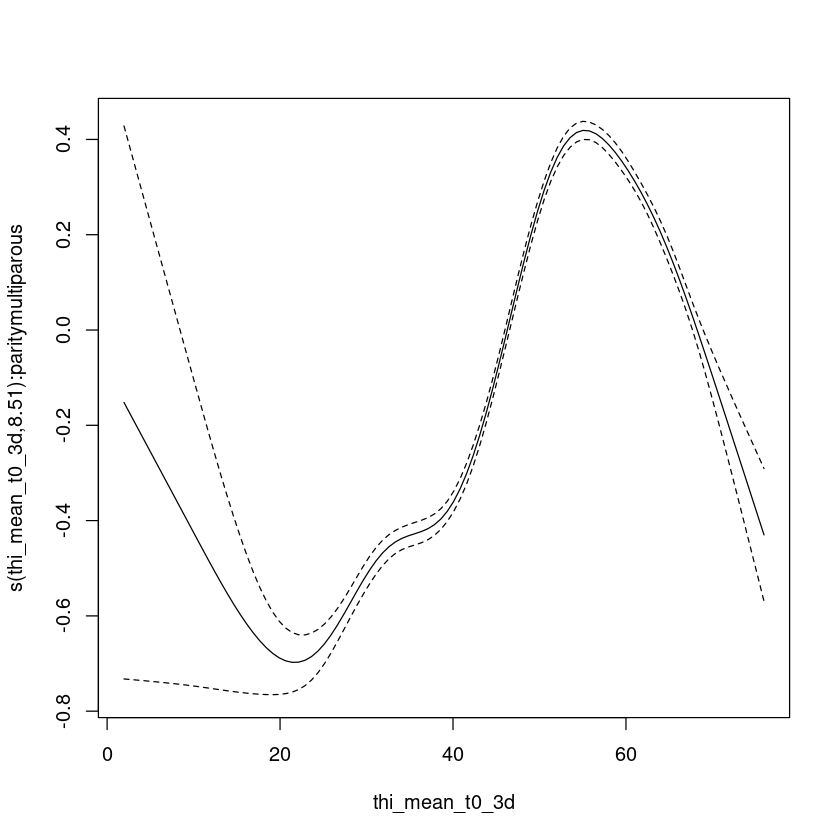

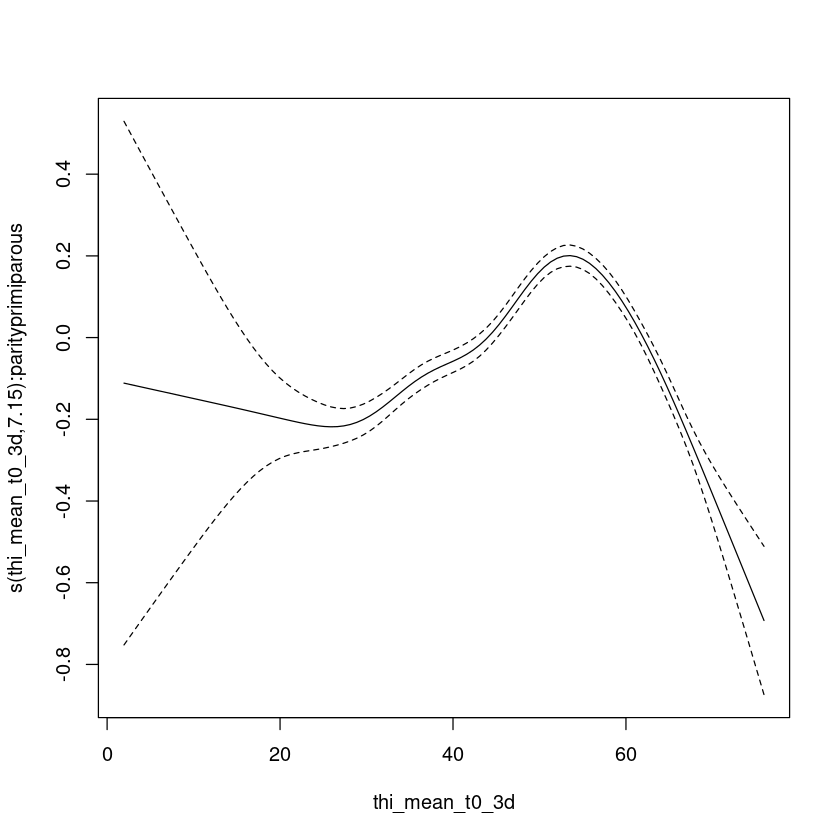

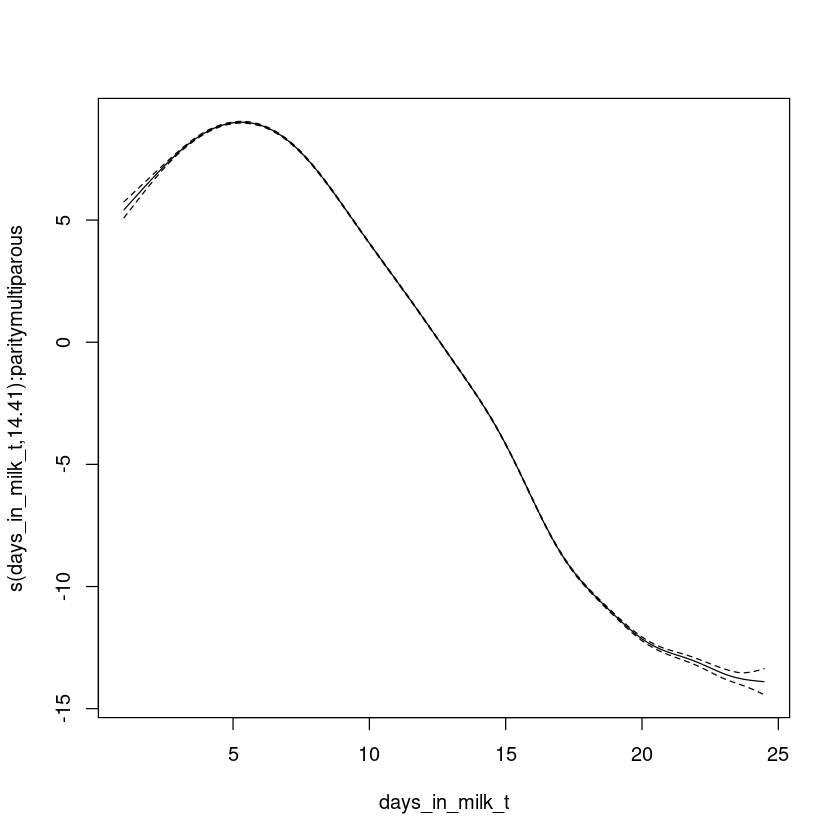

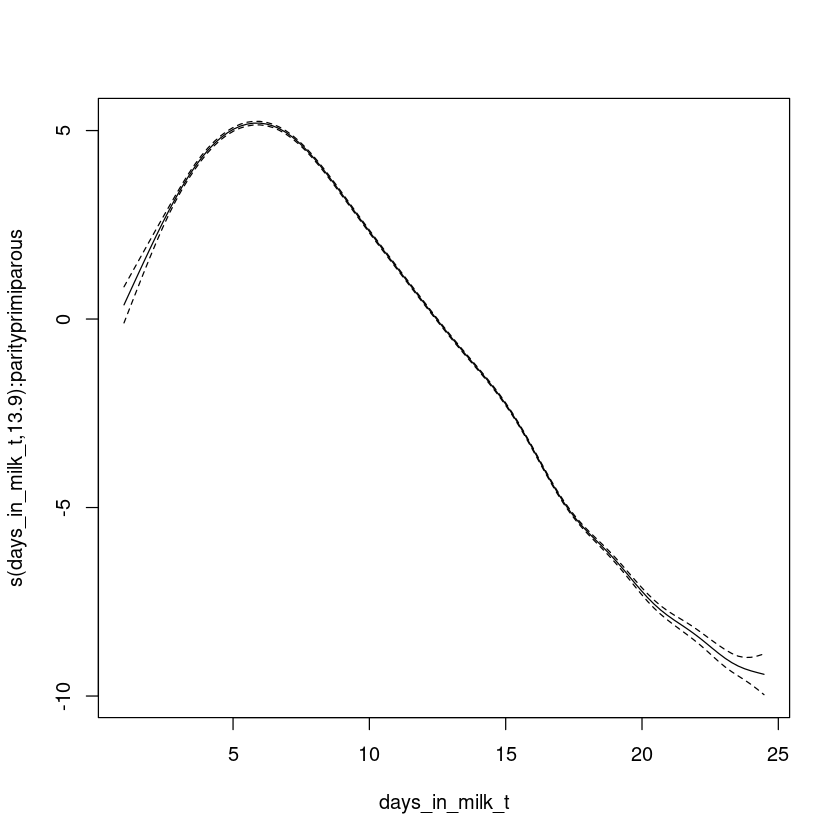

In [109]:
plot(ret$gam, scale=0)

In [110]:
# compute inflection points and the corresponding y values
tic()
# Define the function
extract_unique_smooth_variables <- function(gam_model) {
  # Check if the input model is of class 'gam'
  if (!inherits(gam_model, "gam")) {
    stop("The provided model is not a GAM model. Please provide a model fitted using mgcv::gam.")
  }
  
  # Extract the smooth terms from the model
  smooth_terms <- gam_model$smooth
  
  # Get variable names associated with each smooth term
  all_variable_names <- unlist(lapply(smooth_terms, function(smooth) smooth$term[[1]]))
  # Take unique variable names
  unique_variable_names <- unique(all_variable_names)
  
  return(unique_variable_names)
}
                                      
# Assuming `derivatives` is the output and `first_derivative` has been calculated
first_derivative <- derivatives(ret$gam, type = "central", order = 1, n = 20000)

# List of column names you want to iterate over
column_list <- extract_unique_smooth_variables(ret$gam)  # Replace with your actual column names

# Find where the first derivative changes from positive to negative
inflection_points <- with(first_derivative, {
  signs <- sign(.derivative)  # Assuming the column name for the derivative is '.derivative'
  change_points <- which(diff(signs) < 0)  # Find where the sign changes from positive to negative
  
  # Initialize an empty data frame to store results
  avg_values_df <- data.frame(matrix(ncol = length(column_list), nrow = length(change_points)))
  colnames(avg_values_df) <- column_list
  
  # Iterate over the column list
  for (col_name in column_list) {
    # Calculate the average values for the current column
    avg_values <- sapply(change_points, function(idx) {
      val1 <- first_derivative[[col_name]][[idx]]   # Value at the previous point
      val2 <- first_derivative[[col_name]][[idx + 1]]  # Value at the changepoint
      mean(c(val1, val2))  # Calculate the average
    })
    
    # Add the column to the result data frame
    avg_values_df[[paste0(col_name)]] <- avg_values
  }

    # Combine all relevant information into a final data frame
  inflection_df <- data.frame(
    avg_values_df,
    derivative_at_change = first_derivative$.derivative[change_points + 1], # Derivative value at the change point
    first_derivative[change_points + 1, c(".smooth", ".by", "parity") ]  # Include other relevant columns if needed
  )
  
  inflection_df
})

inflection_points$y <- NA
for (col in column_list) {
    # for each variable
    selected_inf_points <- inflection_points[startsWith(inflection_points[[".smooth"]], paste0("s(",col,")")),]
    smooth_cands <- unique(inflection_points[rownames(selected_inf_points), ".smooth"])
    for (if_smooth in smooth_cands) {
        # for each smooth for this variable
        sms <- smooth_estimates(ret$gam, if_smooth, partial_match = TRUE, overall_uncertainty = FALSE, n=10000)
        x = inflection_points[inflection_points$.smooth == if_smooth, col]
        inflection_points[inflection_points$.smooth == if_smooth, "y"] <- approx(sms[[col]], sms$.estimate, xout=x)$y
    }
}
toc()

4.509 sec elapsed


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


[1] "Post-Peak DIM Rate multiparous : -0.0401211031374854 kg/day/DIM"
[1] "Post-Peak DIM Rate primiparous : -0.0259069505905032 kg/day/DIM"


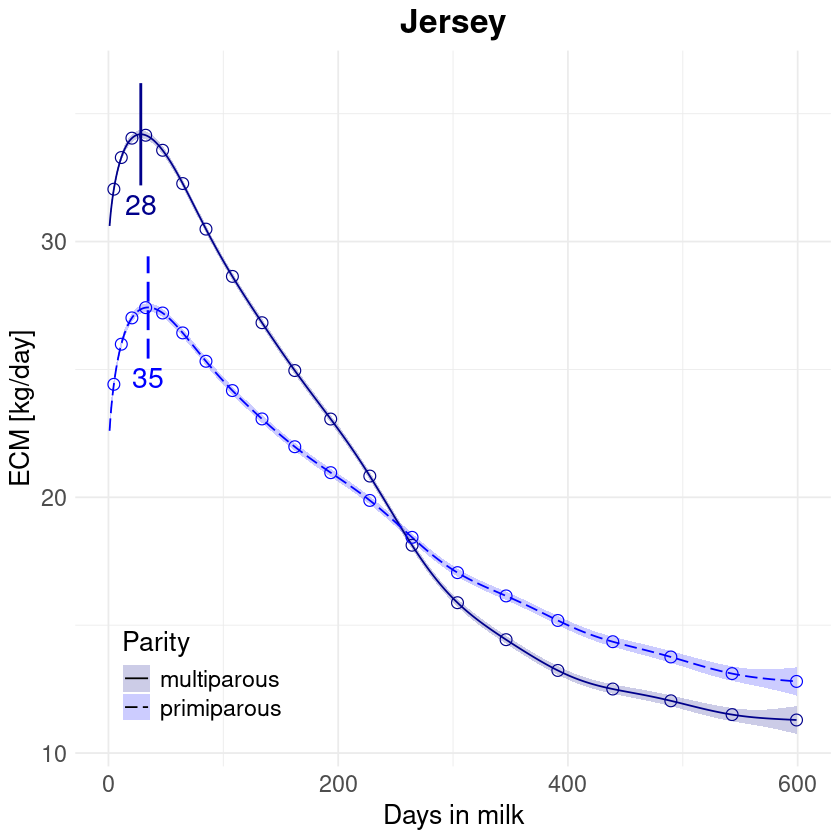

In [111]:
thi_var <- "days_in_milk_t"
x_title <- "Days in milk"
y_title <- "ECM [kg/day]"
main_title <- "Jersey"
line_types <- c("primiparous" = "longdash", "multiparous" = "solid")
line_colors <- c("primiparous" = "blue", "multiparous" = "darkblue")
breed_symbol <- 1
compute_loss_rate <- TRUE

n = 10000
year_intercept_var <- paste0("year",max(as.numeric(levels(df_subsample$year))[df_subsample$year]))
selected_inflection_points <- inflection_points[startsWith(inflection_points$.smooth, paste0("s(", thi_var, ")")),]

# Extract the intercept, parityprimiparous coefficient, and year2023 coefficient from the GAM model
intercept <- coef(ret$gam)["(Intercept)"]
parityprimiparous_intercept <- coef(ret$gam)["parityprimiparous"]
year_intercept <- coef(ret$gam)[year_intercept_var]

selected_inflection_points$y <- selected_inflection_points$y + year_intercept + intercept

selected_inflection_points <- selected_inflection_points |>
  mutate(
     y = ifelse(parity == "primiparous", y + parityprimiparous_intercept, y)
  )

# Add a column for y positions to prevent overlapping (alternate between -1 and -1.5)
selected_inflection_points$y_position <- selected_inflection_points$y + 
                                         ifelse(seq_len(nrow(selected_inflection_points)) %% 2 == 0, -.2, -.5)

sms <- smooth_estimates(ret$gam, paste0("s(",thi_var,")"), partial_match = TRUE, overall_uncertainty = TRUE, n=n) |>
  add_confint()


# Add the intercept to all smooth estimates and confidence intervals
sms <- sms |>
  mutate(
    .estimate = .estimate + intercept + year_intercept,
    .lower_ci = .lower_ci + intercept + year_intercept,
    .upper_ci = .upper_ci + intercept + year_intercept
  )

# For primiparous group, add the parityprimiparous coefficient
sms <- sms |>
  mutate(
    .estimate = ifelse(parity == "primiparous", .estimate + parityprimiparous_intercept, .estimate),
    .lower_ci = ifelse(parity == "primiparous", .lower_ci + parityprimiparous_intercept, .lower_ci),
    .upper_ci = ifelse(parity == "primiparous", .upper_ci + parityprimiparous_intercept, .upper_ci)
  )

sms |>
  ggplot(aes(x = (.data[[thi_var]])^2, y = .estimate, colour = parity)) +
  geom_ribbon(aes(x = (.data[[thi_var]])^2, ymin = .lower_ci, ymax = .upper_ci, fill = parity),
              inherit.aes = FALSE, alpha = 0.2) +
  geom_line(aes(linetype = parity)) +
  scale_linetype_manual(values = line_types) +
  # Set custom colors for parity groups
  scale_color_manual(values = line_colors) +
  scale_fill_manual(values = line_colors) +
  geom_point(data = sms %>% filter(row_number() %% round(n/20) == 0), 
             aes(x = (.data[[thi_var]])^2),
             size = 3, shape = breed_symbol, show.legend = FALSE) +  # Set show.legend = FALSE to remove points from the legend
  geom_segment(data = selected_inflection_points, 
               aes(x = (.data[[paste0(thi_var)]])^2, 
                   xend = (.data[[paste0(thi_var)]])^2, 
                   y = y - 2, 
                   yend = y + 2, 
                   colour = parity, 
                   linetype = parity),  
               size = 0.8, 
               show.legend = FALSE) +
  # Adjusting the geom_text to place labels just below the vertical lines
  geom_text(data = selected_inflection_points, 
            aes(x = (.data[[paste0(thi_var)]])^2, 
                y = y - 0.7,  # Adjust the y position slightly below y - 0.5
                label = round((.data[[paste0(thi_var)]])^2, 0), 
                colour = parity), 
            angle = 0, 
            vjust = 3,  # Ensure the text is aligned above the set y position
            hjust = 0.5,  # Center the text directly underneath the line
            size = 6, 
            show.legend = FALSE) +
  labs(
    title = main_title,
    x = x_title,  # Update the x title to indicate it's squared
    y = y_title,
    colour = "Parity",
    fill = "Parity",
    linetype = "Parity"
  ) +
  theme_minimal() +  
  theme(
    plot.title = element_text(size = 20, face = "bold", family = "Helvetica", hjust = 0.5),
    axis.title.x = element_text(size = 16, family = "Helvetica"),
    axis.title.y = element_text(size = 16, family = "Helvetica"),
    axis.text.x = element_text(size = 14, family = "Helvetica"),
    axis.text.y = element_text(size = 14, family = "Helvetica"),
    legend.title = element_text(size = 16, family = "Helvetica"),
    legend.text = element_text(size = 14, family = "Helvetica"),
    legend.position = c(0.05, 0.05),
    legend.justification = c(0, 0)
  ) +
  guides(
    colour = "none",  # Remove the colour guide (removing circles from the legend)
    linetype = guide_legend(override.aes = list(shape = NA))  # Ensure only lines are shown in the legend
  )

if (compute_loss_rate) {
    for (p in unique(sms$parity)) {
    sms_p <- sms[sms$parity == p,]
    p_inf <- selected_inflection_points[selected_inflection_points$parity == p,]

    if (nrow(p_inf) > 0 ){
        max_row <- sms_p[which.max(sms_p[[thi_var]]), ]
        max_y <- max_row$.estimate
        max_x <- max_row[[thi_var]]^2
        max_t_row <- p_inf[which.max(p_inf[[thi_var]]), ]
        t_y <- max_t_row$y
        t_x <- max_t_row[[thi_var]]^2
        rate = (max_y - t_y)/(max_x - t_x)
        print(paste0("Post-Peak DIM Rate ", p, " : ", rate, " kg/day/DIM"))
    }
}
}

Warning message:
“Removed 7580 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range (`geom_point()`).”


[1] "THI Post-Peak Rate multiparous : -0.0409850940265474 kg/day/THI"
[1] "THI Post-Peak Rate primiparous : -0.039589561136378 kg/day/THI"


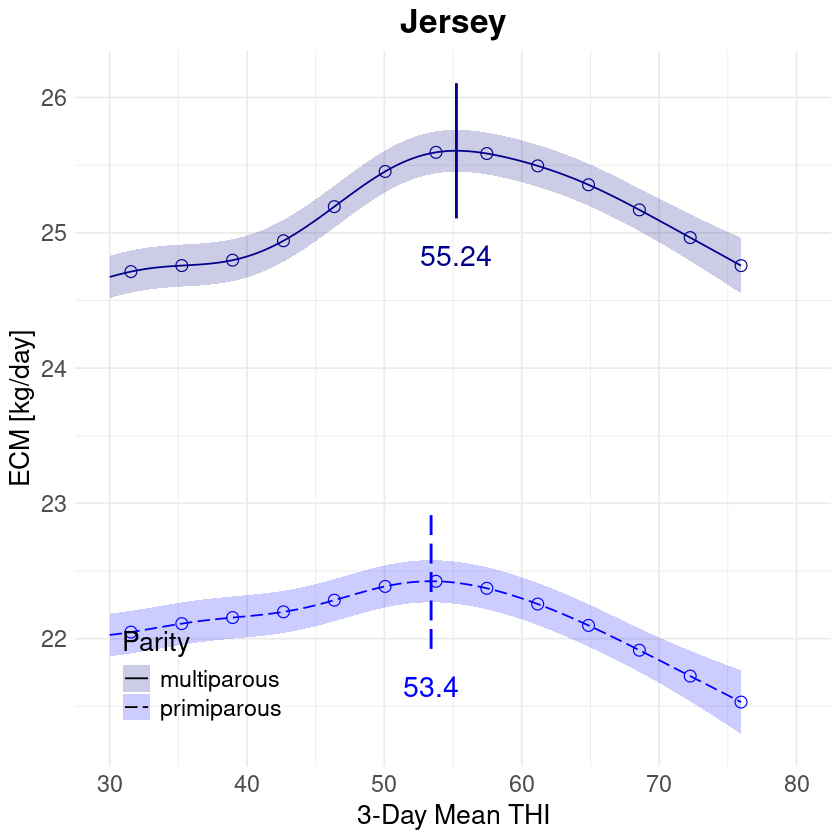

In [112]:
thi_var <- "thi_mean_t0_3d"
x_title <- "3-Day Mean THI"
y_title <- "ECM [kg/day]"
main_title <- "Jersey"
line_types <- c("primiparous" = "longdash", "multiparous" = "solid")
line_colors <- c("primiparous" = "blue", "multiparous" = "darkblue")
breed_symbol <- 1
compute_loss_rate <- TRUE

n = 10000
year_intercept_var <- paste0("year",max(as.numeric(levels(df_subsample$year))[df_subsample$year]))
selected_inflection_points <- inflection_points[startsWith(inflection_points$.smooth, paste0("s(", thi_var, ")")),]

# Extract the intercept, parityprimiparous coefficient, and year2023 coefficient from the GAM model
intercept <- coef(ret$gam)["(Intercept)"]
parityprimiparous_intercept <- coef(ret$gam)["parityprimiparous"]
year_intercept <- coef(ret$gam)[year_intercept_var]

selected_inflection_points$y <- selected_inflection_points$y + year_intercept + intercept

selected_inflection_points <- selected_inflection_points |>
  mutate(
     y = ifelse(parity == "primiparous", y + parityprimiparous_intercept, y)
  )

# Add a column for y positions to prevent overlapping (alternate between -1 and -1.5)
selected_inflection_points$y_position <- selected_inflection_points$y + 
                                         ifelse(seq_len(nrow(selected_inflection_points)) %% 2 == 0, -.2, -.5)

sms <- smooth_estimates(ret$gam, paste0("s(",thi_var,")"), partial_match = TRUE, overall_uncertainty = TRUE, n=n) |>
  add_confint()


# Add the intercept to all smooth estimates and confidence intervals
sms <- sms |>
  mutate(
    .estimate = .estimate + intercept + year_intercept,
    .lower_ci = .lower_ci + intercept + year_intercept,
    .upper_ci = .upper_ci + intercept + year_intercept
  )

# For primiparous group, add the parityprimiparous coefficient
sms <- sms |>
  mutate(
    .estimate = ifelse(parity == "primiparous", .estimate + parityprimiparous_intercept, .estimate),
    .lower_ci = ifelse(parity == "primiparous", .lower_ci + parityprimiparous_intercept, .lower_ci),
    .upper_ci = ifelse(parity == "primiparous", .upper_ci + parityprimiparous_intercept, .upper_ci)
  )

# Filter the sms data to the selected x range (30 to 80)
filtered_sms <- sms |>
  filter(.data[[thi_var]] >= 30 & .data[[thi_var]] <= 80)

# Determine the y-axis limits based on the filtered data
y_min <- min(filtered_sms$.lower_ci, na.rm = TRUE)
y_max <- max(filtered_sms$.upper_ci, na.rm = TRUE)

sms |>
  ggplot(aes(x = .data[[thi_var]], y = .estimate, colour = parity)) +
  geom_ribbon(aes(x = .data[[thi_var]], ymin = .lower_ci, ymax = .upper_ci, fill = parity),
              inherit.aes = FALSE, alpha = 0.2) +
  geom_line(aes(linetype = parity)) +
  scale_linetype_manual(values = line_types) +
  # Set custom colors for parity groups
  scale_color_manual(values = line_colors) +
  scale_fill_manual(values = line_colors) +
  geom_point(data = sms %>% filter(row_number() %% round(n/20) == 0), 
             size = 3, shape = breed_symbol, show.legend = FALSE) +  # Set show.legend = FALSE to remove points from the legend
  geom_segment(data = selected_inflection_points, 
               aes(x = .data[[paste0(thi_var)]], 
                   xend = .data[[paste0(thi_var)]], 
                   y = y - 0.5, 
                   yend = y + 0.5, 
                   colour = parity, 
                   linetype = parity),  
               size = 0.8, 
               show.legend = FALSE) +
  # Adjusting the geom_text to place labels just below the vertical lines
  geom_text(data = selected_inflection_points, 
            aes(x = .data[[paste0(thi_var)]], 
                y = y - 0.7,  # Adjust the y position slightly below y - 0.5
                label = round(.data[[paste0(thi_var)]], 2), 
                colour = parity), 
            angle = 0, 
            vjust = 1,  # Ensure the text is aligned above the set y position
            hjust = 0.5,  # Center the text directly underneath the line
            size = 6, 
            show.legend = FALSE) +
  xlim(30, 80) +  
  labs(
    title = main_title,
    x = x_title,
    y = y_title,
    colour = "Parity",
    fill = "Parity",
    linetype = "Parity"
  ) +
  theme_minimal() +  
  theme(
    plot.title = element_text(size = 20, face = "bold", family = "Helvetica", hjust = 0.5),
    axis.title.x = element_text(size = 16, family = "Helvetica"),
    axis.title.y = element_text(size = 16, family = "Helvetica"),
    axis.text.x = element_text(size = 14, family = "Helvetica"),
    axis.text.y = element_text(size = 14, family = "Helvetica"),
    legend.title = element_text(size = 16, family = "Helvetica"),
    legend.text = element_text(size = 14, family = "Helvetica"),
    legend.position = c(0.05, 0.05),
    legend.justification = c(0, 0)
  ) +
  guides(
    colour = "none",  # Remove the colour guide (removing circles from the legend)
    linetype = guide_legend(override.aes = list(shape = NA))  # Ensure only lines are shown in the legend
  )

if (compute_loss_rate) {
    for (p in unique(sms$parity)) {
    sms_p <- sms[sms$parity == p,]
    p_inf <- selected_inflection_points[selected_inflection_points$parity == p,]

    if (nrow(p_inf) > 0 ){
        max_row <- sms_p[which.max(sms_p[[thi_var]]), ]
        max_y <- max_row$.estimate
        max_x <- max_row[[thi_var]]
        max_t_row <- p_inf[which.max(p_inf[[thi_var]]), ]
        t_y <- max_t_row$y
        t_x <- max_t_row[[thi_var]]
        rate = (max_y - t_y)/(max_x - t_x)
        print(paste0("THI Post-Peak Rate ", p, " : ", rate, " kg/day/THI"))
    }
}
}

In [113]:
b <- getViz(ret$gam)

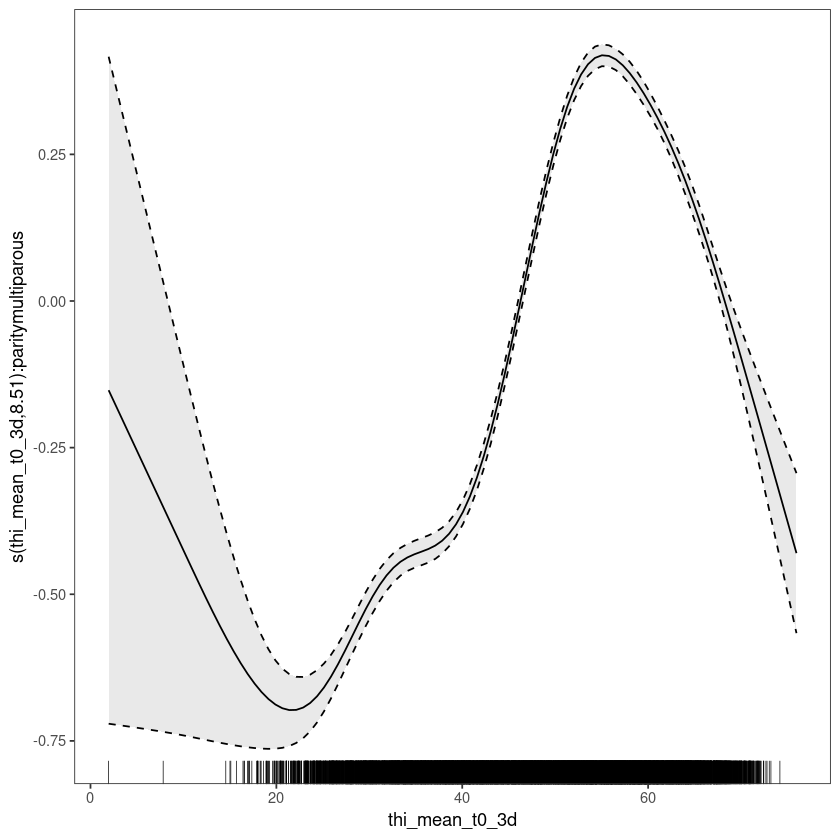

In [114]:
plot(sm(b, 1)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug()# +
  #geom_vline(xintercept = 53, color = "red", linetype = "dashed", size = 1)

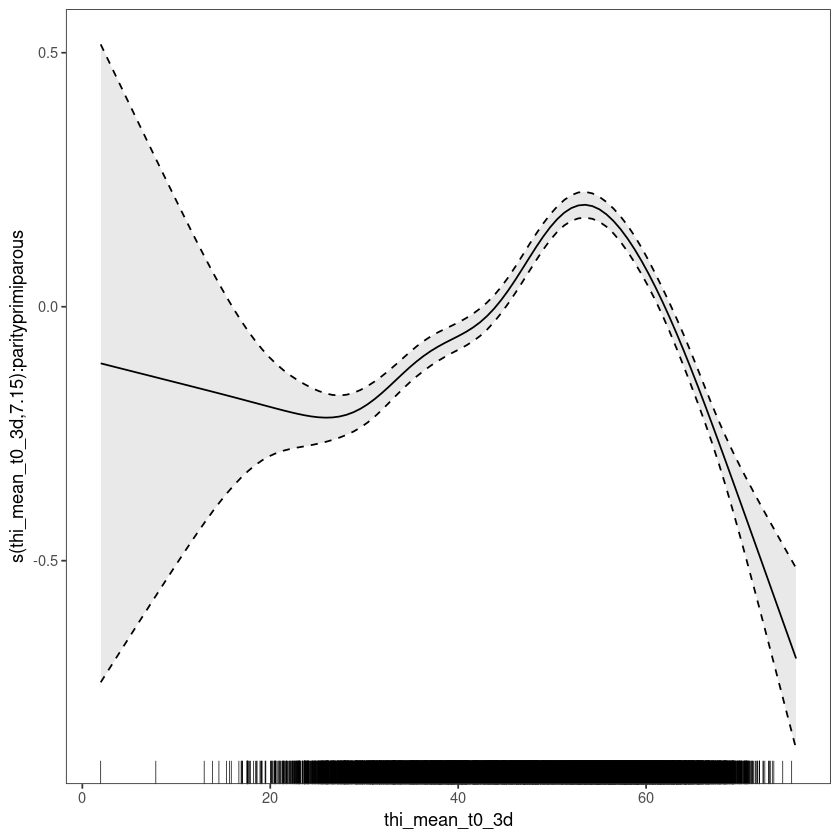

In [115]:
plot(sm(b, 2)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug()# +

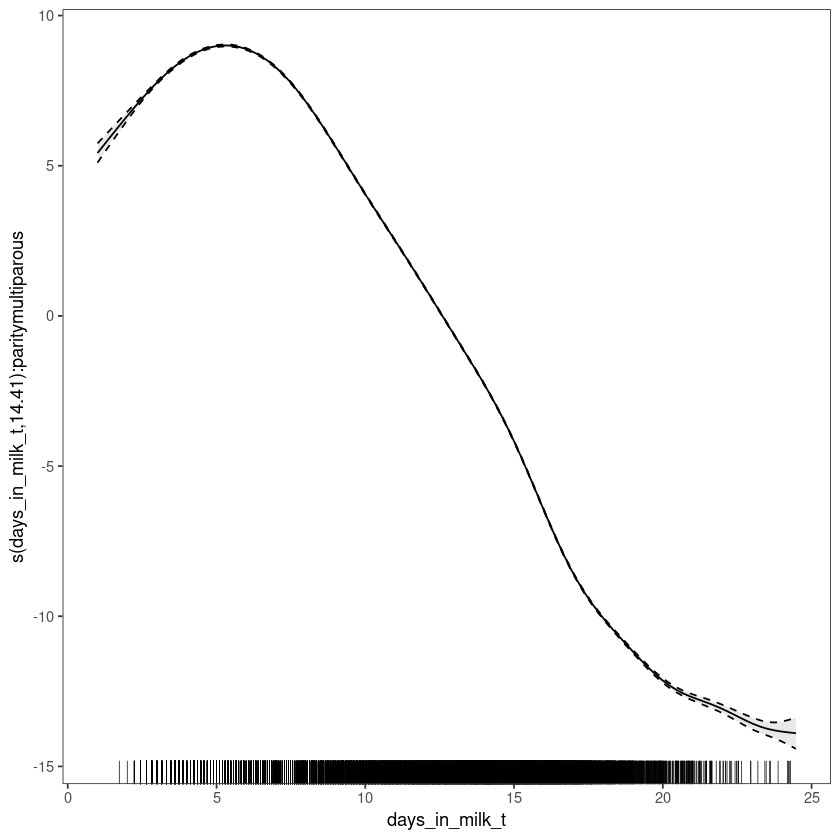

In [116]:
plot(sm(b, 3)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug()# +

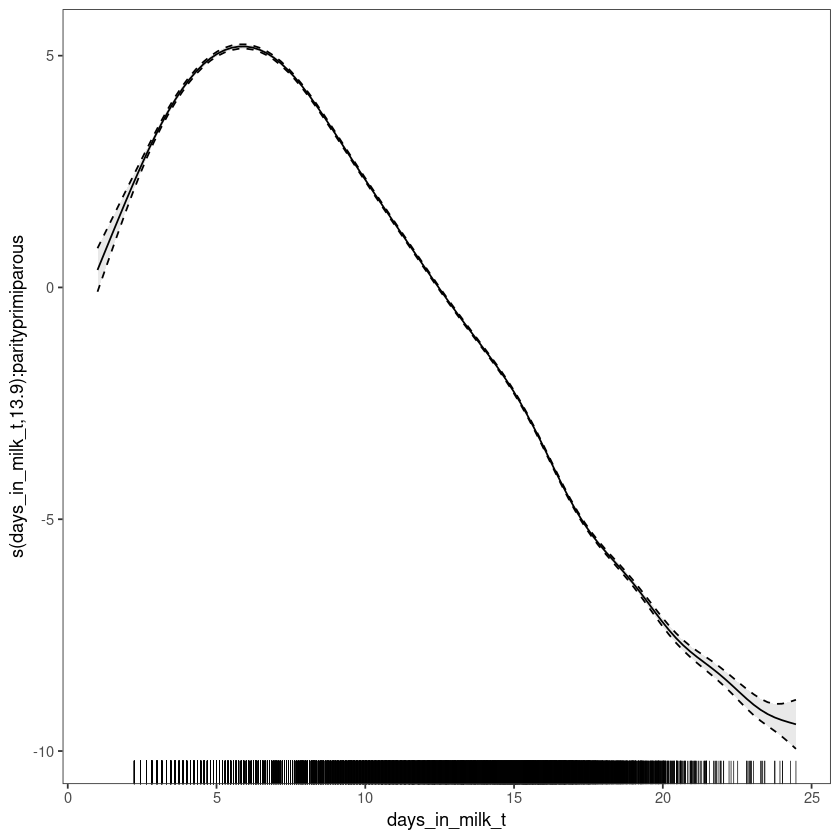

In [117]:
plot(sm(b, 4)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug()# +

In [118]:
inflection_points

,thi_mean_t0_3d,days_in_milk_t,derivative_at_change,.smooth,.by,parity,y
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
14402,55.24493,NA,-2.102101e-05,s(thi_mean_t0_3d):paritymultiparous,parity,multiparous,0.4191885
13904,53.40199,NA,-1.495989e-05,s(thi_mean_t0_3d):parityprimiparous,parity,primiparous,0.2007569
3670,NA,5.306021,-4.371563e-04,s(days_in_milk_t):paritymultiparous,parity,multiparous,9.0075927
4156,NA,5.876479,-4.204963e-04,s(days_in_milk_t):parityprimiparous,parity,primiparous,5.1998699


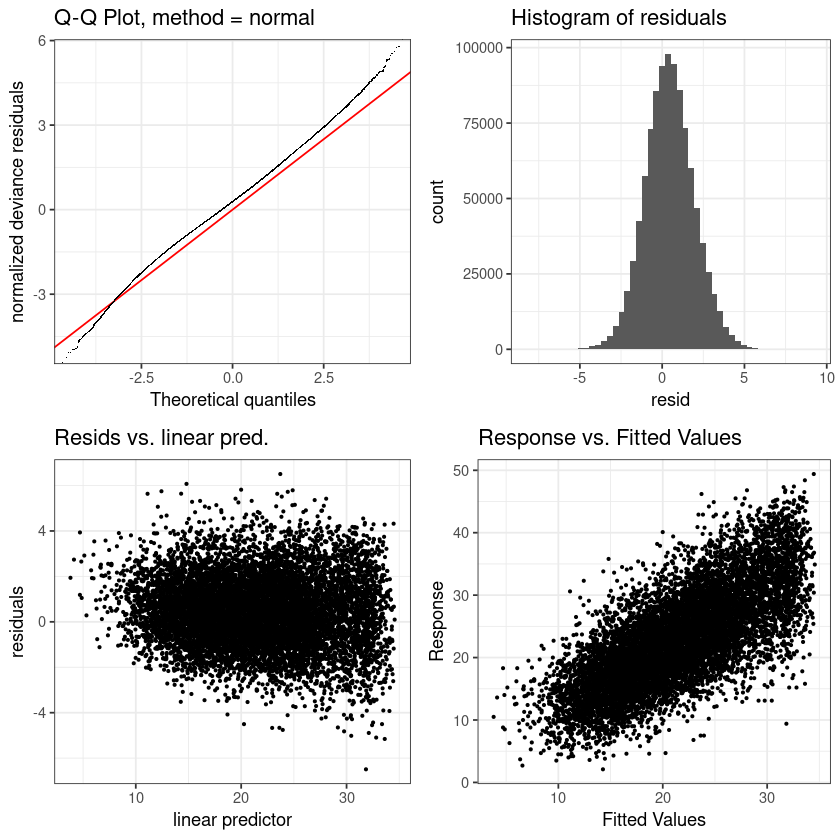

In [119]:
check(b,
      type = "tnormal",
      a.qq = list( 
                  a.cipoly = list(fill = "light blue")), 
      a.respoi = list(size = 0.5), 
      a.hist = list(bins = 50))

In [120]:
tic()
saveRDS(ret$gam,file=model_fname, compress="gzip")
toc()

4.833 sec elapsed


In [121]:
tic()
saveRDS(b,file=plot_fname, compress="gzip")
toc()

5.299 sec elapsed


In [4]:
ret <- list()
ret$gam <- readRDS(model_fname)
b <- readRDS(plot_fname)

In [5]:
# compute inflection points and the corresponding y values
tic()
# Define the function
extract_unique_smooth_variables <- function(gam_model) {
  # Check if the input model is of class 'gam'
  if (!inherits(gam_model, "gam")) {
    stop("The provided model is not a GAM model. Please provide a model fitted using mgcv::gam.")
  }
  
  # Extract the smooth terms from the model
  smooth_terms <- gam_model$smooth
  
  # Get variable names associated with each smooth term
  all_variable_names <- unlist(lapply(smooth_terms, function(smooth) smooth$term[[1]]))
  # Take unique variable names
  unique_variable_names <- unique(all_variable_names)
  
  return(unique_variable_names)
}
                                      
# Assuming `derivatives` is the output and `first_derivative` has been calculated
first_derivative <- derivatives(ret$gam, type = "central", order = 1, n = 20000)

# List of column names you want to iterate over
column_list <- extract_unique_smooth_variables(ret$gam)  # Replace with your actual column names

# Find where the first derivative changes from positive to negative
inflection_points <- with(first_derivative, {
  signs <- sign(.derivative)  # Assuming the column name for the derivative is '.derivative'
  change_points <- which(diff(signs) < 0)  # Find where the sign changes from positive to negative
  
  # Initialize an empty data frame to store results
  avg_values_df <- data.frame(matrix(ncol = length(column_list), nrow = length(change_points)))
  colnames(avg_values_df) <- column_list
  
  # Iterate over the column list
  for (col_name in column_list) {
    # Calculate the average values for the current column
    avg_values <- sapply(change_points, function(idx) {
      val1 <- first_derivative[[col_name]][[idx]]   # Value at the previous point
      val2 <- first_derivative[[col_name]][[idx + 1]]  # Value at the changepoint
      mean(c(val1, val2))  # Calculate the average
    })
    
    # Add the column to the result data frame
    avg_values_df[[paste0(col_name)]] <- avg_values
  }

    # Combine all relevant information into a final data frame
  inflection_df <- data.frame(
    avg_values_df,
    derivative_at_change = first_derivative$.derivative[change_points + 1], # Derivative value at the change point
    first_derivative[change_points + 1, c(".smooth", ".by", "parity") ]  # Include other relevant columns if needed
  )
  
  inflection_df
})

inflection_points$y <- NA
for (col in column_list) {
    # for each variable
    selected_inf_points <- inflection_points[startsWith(inflection_points[[".smooth"]], paste0("s(",col,")")),]
    smooth_cands <- unique(inflection_points[rownames(selected_inf_points), ".smooth"])
    for (if_smooth in smooth_cands) {
        # for each smooth for this variable
        sms <- smooth_estimates(ret$gam, if_smooth, partial_match = TRUE, overall_uncertainty = FALSE, n=10000)
        x = inflection_points[inflection_points$.smooth == if_smooth, col]
        inflection_points[inflection_points$.smooth == if_smooth, "y"] <- approx(sms[[col]], sms$.estimate, xout=x)$y
    }
}
toc()

5.131 sec elapsed


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


[1] "Post-Peak DIM Rate multiparous : -0.0401211031374854 kg/day/DIM"
[1] "Post-Peak DIM Rate primiparous : -0.0259069505905032 kg/day/DIM"


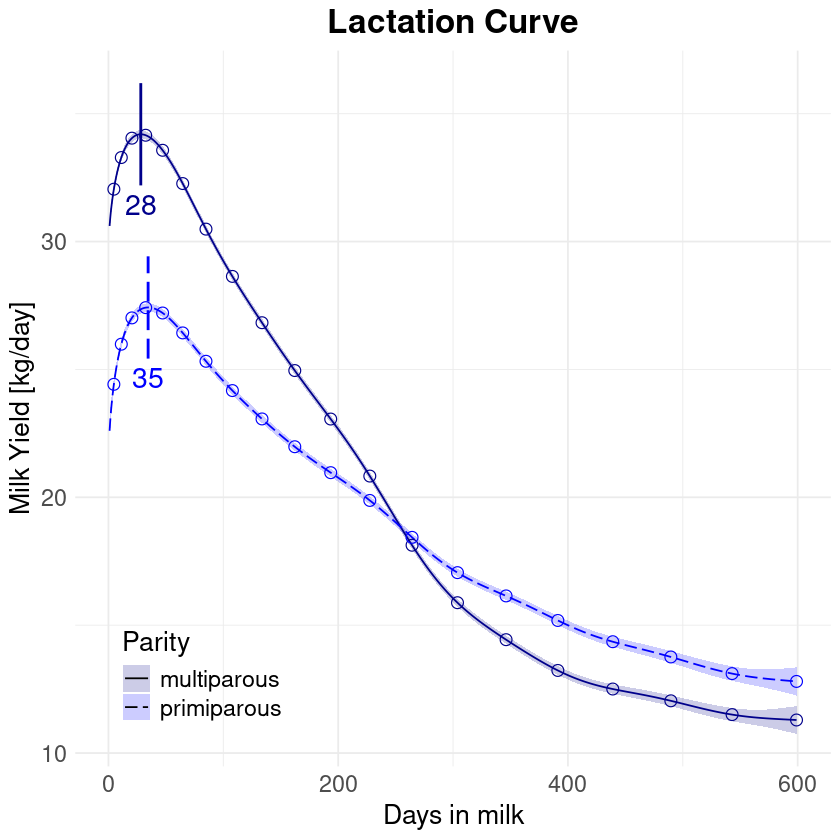

In [6]:
thi_var <- "days_in_milk_t"
x_title <- "Days in milk"
y_title <- "Milk Yield [kg/day]"
main_title <- "Lactation Curve"
line_types <- c("primiparous" = "longdash", "multiparous" = "solid")
line_colors <-  c("primiparous" = "blue", "multiparous" = "darkblue")
breed_symbol <- 1
compute_loss_rate <- TRUE

n = 10000
year_intercept_var <- paste0("year","2010")
selected_inflection_points <- inflection_points[startsWith(inflection_points$.smooth, paste0("s(", thi_var, ")")),]

# Extract the intercept, parityprimiparous coefficient, and year2023 coefficient from the GAM model
intercept <- coef(ret$gam)["(Intercept)"]
parityprimiparous_intercept <- coef(ret$gam)["parityprimiparous"]
year_intercept <- coef(ret$gam)[year_intercept_var]

selected_inflection_points$y <- selected_inflection_points$y + year_intercept + intercept

selected_inflection_points <- selected_inflection_points |>
  mutate(
     y = ifelse(parity == "primiparous", y + parityprimiparous_intercept, y)
  )

# Add a column for y positions to prevent overlapping (alternate between -1 and -1.5)
selected_inflection_points$y_position <- selected_inflection_points$y + 
                                         ifelse(seq_len(nrow(selected_inflection_points)) %% 2 == 0, -.2, -.5)

sms <- smooth_estimates(ret$gam, paste0("s(",thi_var,")"), partial_match = TRUE, overall_uncertainty = TRUE, n=n) |>
  add_confint()


# Add the intercept to all smooth estimates and confidence intervals
sms <- sms |>
  mutate(
    .estimate = .estimate + intercept + year_intercept,
    .lower_ci = .lower_ci + intercept + year_intercept,
    .upper_ci = .upper_ci + intercept + year_intercept
  )

# For primiparous group, add the parityprimiparous coefficient
sms <- sms |>
  mutate(
    .estimate = ifelse(parity == "primiparous", .estimate + parityprimiparous_intercept, .estimate),
    .lower_ci = ifelse(parity == "primiparous", .lower_ci + parityprimiparous_intercept, .lower_ci),
    .upper_ci = ifelse(parity == "primiparous", .upper_ci + parityprimiparous_intercept, .upper_ci)
  )

sms |>
  ggplot(aes(x = (.data[[thi_var]])^2, y = .estimate, colour = parity)) +
  geom_ribbon(aes(x = (.data[[thi_var]])^2, ymin = .lower_ci, ymax = .upper_ci, fill = parity),
              inherit.aes = FALSE, alpha = 0.2) +
  geom_line(aes(linetype = parity)) +
  scale_linetype_manual(values = line_types) +
  # Set custom colors for parity groups
  scale_color_manual(values = line_colors) +
  scale_fill_manual(values = line_colors) +
  geom_point(data = sms %>% filter(row_number() %% round(n/20) == 0), 
             aes(x = (.data[[thi_var]])^2),
             size = 3, shape = breed_symbol, show.legend = FALSE) +  # Set show.legend = FALSE to remove points from the legend
  geom_segment(data = selected_inflection_points, 
               aes(x = (.data[[paste0(thi_var)]])^2, 
                   xend = (.data[[paste0(thi_var)]])^2, 
                   y = y - 2, 
                   yend = y + 2, 
                   colour = parity, 
                   linetype = parity),  
               size = 0.8, 
               show.legend = FALSE) +
  # Adjusting the geom_text to place labels just below the vertical lines
  geom_text(data = selected_inflection_points, 
            aes(x = (.data[[paste0(thi_var)]])^2, 
                y = y - 0.7,  # Adjust the y position slightly below y - 0.5
                label = round((.data[[paste0(thi_var)]])^2, 0), 
                colour = parity), 
            angle = 0, 
            vjust = 3,  # Ensure the text is aligned above the set y position
            hjust = 0.5,  # Center the text directly underneath the line
            size = 6, 
            show.legend = FALSE) +
  labs(
    title = main_title,
    x = x_title,  # Update the x title to indicate it's squared
    y = y_title,
    colour = "Parity",
    fill = "Parity",
    linetype = "Parity"
  ) +
  theme_minimal() +  
  theme(
    plot.title = element_text(size = 20, face = "bold", family = "Helvetica", hjust = 0.5),
    axis.title.x = element_text(size = 16, family = "Helvetica"),
    axis.title.y = element_text(size = 16, family = "Helvetica"),
    axis.text.x = element_text(size = 14, family = "Helvetica"),
    axis.text.y = element_text(size = 14, family = "Helvetica"),
    legend.title = element_text(size = 16, family = "Helvetica"),
    legend.text = element_text(size = 14, family = "Helvetica"),
    legend.position = c(0.05, 0.05),
    legend.justification = c(0, 0)
  ) +
  guides(
    colour = "none",  # Remove the colour guide (removing circles from the legend)
    linetype = guide_legend(override.aes = list(shape = NA))  # Ensure only lines are shown in the legend
  )

if (compute_loss_rate) {
    for (p in unique(sms$parity)) {
    sms_p <- sms[sms$parity == p,]
    p_inf <- selected_inflection_points[selected_inflection_points$parity == p,]

    if (nrow(p_inf) > 0 ){
        max_row <- sms_p[which.max(sms_p[[thi_var]]), ]
        max_y <- max_row$.estimate
        max_x <- max_row[[thi_var]]^2
        max_t_row <- p_inf[which.max(p_inf[[thi_var]]), ]
        t_y <- max_t_row$y
        t_x <- max_t_row[[thi_var]]^2
        rate = (max_y - t_y)/(max_x - t_x)
        print(paste0("Post-Peak DIM Rate ", p, " : ", rate, " kg/day/DIM"))
    }
}
}
ggsave("ho_milk_before2010_marginal_dim_milk_combined.png", width = 6, height = 6)

[1] "THI Post-Peak Rate multiparous : -0.0409850940265474 kg/day/THI"
[1] "THI Post-Peak Rate primiparous : -0.039589561136378 kg/day/THI"


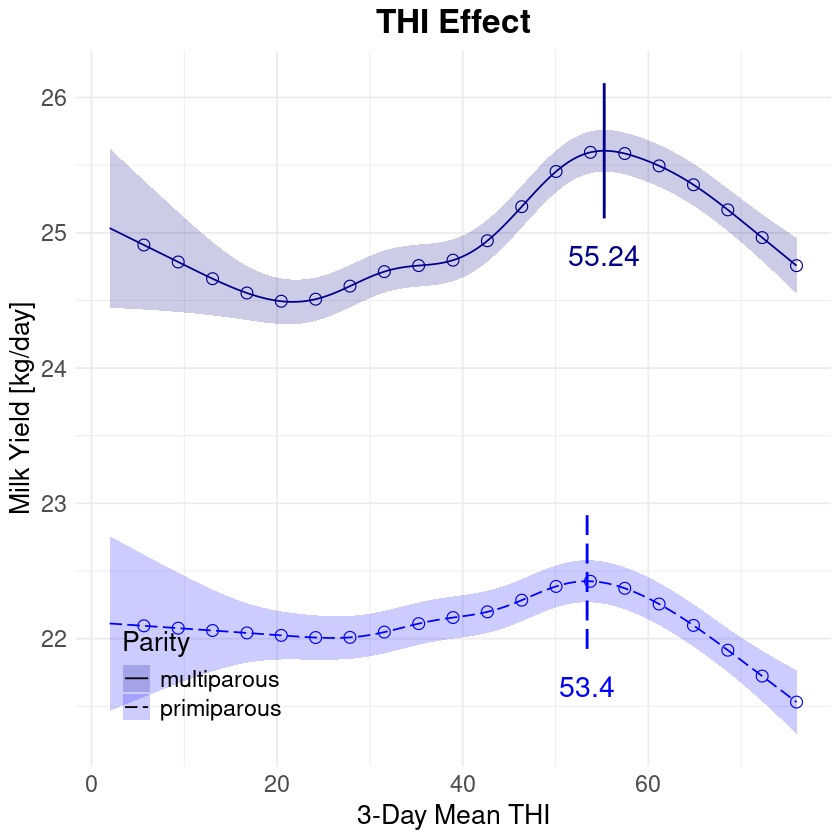

In [7]:
thi_var <- "thi_mean_t0_3d"
x_title <- "3-Day Mean THI"
y_title <- "Milk Yield [kg/day]"
main_title <- "THI Effect"
line_types <- c("primiparous" = "longdash", "multiparous" = "solid")
line_colors <-  c("primiparous" = "blue", "multiparous" = "darkblue")
breed_symbol <- 1
compute_loss_rate <- TRUE

n = 10000
year_intercept_var <- paste0("year","2010")
selected_inflection_points <- inflection_points[startsWith(inflection_points$.smooth, paste0("s(", thi_var, ")")),]

# Extract the intercept, parityprimiparous coefficient, and year2023 coefficient from the GAM model
intercept <- coef(ret$gam)["(Intercept)"]
parityprimiparous_intercept <- coef(ret$gam)["parityprimiparous"]
year_intercept <- coef(ret$gam)[year_intercept_var]

selected_inflection_points$y <- selected_inflection_points$y + year_intercept + intercept

selected_inflection_points <- selected_inflection_points |>
  mutate(
     y = ifelse(parity == "primiparous", y + parityprimiparous_intercept, y)
  )

# Add a column for y positions to prevent overlapping (alternate between -1 and -1.5)
selected_inflection_points$y_position <- selected_inflection_points$y + 
                                         ifelse(seq_len(nrow(selected_inflection_points)) %% 2 == 0, -.2, -.5)

sms <- smooth_estimates(ret$gam, paste0("s(",thi_var,")"), partial_match = TRUE, overall_uncertainty = TRUE, n=n) |>
  add_confint()


# Add the intercept to all smooth estimates and confidence intervals
sms <- sms |>
  mutate(
    .estimate = .estimate + intercept + year_intercept,
    .lower_ci = .lower_ci + intercept + year_intercept,
    .upper_ci = .upper_ci + intercept + year_intercept
  )

# For primiparous group, add the parityprimiparous coefficient
sms <- sms |>
  mutate(
    .estimate = ifelse(parity == "primiparous", .estimate + parityprimiparous_intercept, .estimate),
    .lower_ci = ifelse(parity == "primiparous", .lower_ci + parityprimiparous_intercept, .lower_ci),
    .upper_ci = ifelse(parity == "primiparous", .upper_ci + parityprimiparous_intercept, .upper_ci)
  )

# Filter the sms data to the selected x range (30 to 80)
filtered_sms <- sms |>
  filter(.data[[thi_var]] >= 30 & .data[[thi_var]] <= 80)

# Determine the y-axis limits based on the filtered data
y_min <- min(filtered_sms$.lower_ci, na.rm = TRUE)
y_max <- max(filtered_sms$.upper_ci, na.rm = TRUE)

sms |>
  ggplot(aes(x = .data[[thi_var]], y = .estimate, colour = parity)) +
  geom_ribbon(aes(x = .data[[thi_var]], ymin = .lower_ci, ymax = .upper_ci, fill = parity),
              inherit.aes = FALSE, alpha = 0.2) +
  geom_line(aes(linetype = parity)) +
  scale_linetype_manual(values = line_types) +
  # Set custom colors for parity groups
  scale_color_manual(values = line_colors) +
  scale_fill_manual(values = line_colors) +
  geom_point(data = sms %>% filter(row_number() %% round(n/20) == 0), 
             size = 3, shape = breed_symbol, show.legend = FALSE) +  # Set show.legend = FALSE to remove points from the legend
  geom_segment(data = selected_inflection_points, 
               aes(x = .data[[paste0(thi_var)]], 
                   xend = .data[[paste0(thi_var)]], 
                   y = y - 0.5, 
                   yend = y + 0.5, 
                   colour = parity, 
                   linetype = parity),  
               size = 0.8, 
               show.legend = FALSE) +
  # Adjusting the geom_text to place labels just below the vertical lines
  geom_text(data = selected_inflection_points, 
            aes(x = .data[[paste0(thi_var)]], 
                y = y - 0.7,  # Adjust the y position slightly below y - 0.5
                label = round(.data[[paste0(thi_var)]], 2), 
                colour = parity), 
            angle = 0, 
            vjust = 1,  # Ensure the text is aligned above the set y position
            hjust = 0.5,  # Center the text directly underneath the line
            size = 6, 
            show.legend = FALSE) +
  #xlim(30, 80) +  
  labs(
    title = main_title,
    x = x_title,
    y = y_title,
    colour = "Parity",
    fill = "Parity",
    linetype = "Parity"
  ) +
  theme_minimal() +  
  theme(
    plot.title = element_text(size = 20, face = "bold", family = "Helvetica", hjust = 0.5),
    axis.title.x = element_text(size = 16, family = "Helvetica"),
    axis.title.y = element_text(size = 16, family = "Helvetica"),
    axis.text.x = element_text(size = 14, family = "Helvetica"),
    axis.text.y = element_text(size = 14, family = "Helvetica"),
    legend.title = element_text(size = 16, family = "Helvetica"),
    legend.text = element_text(size = 14, family = "Helvetica"),
    legend.position = c(0.05, 0.05),
    legend.justification = c(0, 0)
  ) +
  guides(
    colour = "none",  # Remove the colour guide (removing circles from the legend)
    linetype = guide_legend(override.aes = list(shape = NA))  # Ensure only lines are shown in the legend
  )

if (compute_loss_rate) {
    for (p in unique(sms$parity)) {
    sms_p <- sms[sms$parity == p,]
    p_inf <- selected_inflection_points[selected_inflection_points$parity == p,]

    if (nrow(p_inf) > 0 ){
        max_row <- sms_p[which.max(sms_p[[thi_var]]), ]
        max_y <- max_row$.estimate
        max_x <- max_row[[thi_var]]
        max_t_row <- p_inf[which.max(p_inf[[thi_var]]), ]
        t_y <- max_t_row$y
        t_x <- max_t_row[[thi_var]]
        rate = (max_y - t_y)/(max_x - t_x)
        print(paste0("THI Post-Peak Rate ", p, " : ", rate, " kg/day/THI"))
    }
}
}
ggsave("ho_milk_before2010_marginal_thi_milk_combined.png", width = 6, height = 6)

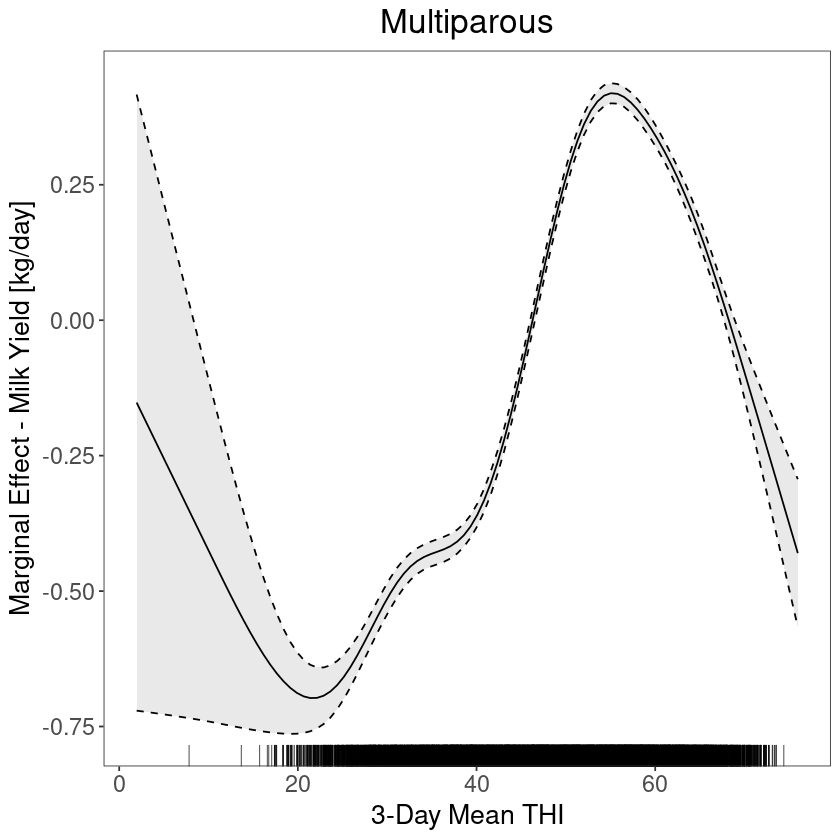

In [8]:
plot(sm(b, 1)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug() +
  labs(title = "Multiparous", 
       x = "3-Day Mean THI", 
       y = "Marginal Effect - Milk Yield [kg/day]") +
theme(plot.title = element_text(hjust = 0.5, size = 20),  # Center title and increase size
        axis.title.x = element_text(size = 16),  # Increase X-axis label size
        axis.title.y = element_text(size = 16),  # Increase Y-axis label size
        axis.text = element_text(size = 14))
ggsave("ho_milk_before2010_marginal_thi_milk_multi.png", width = 6, height = 6)

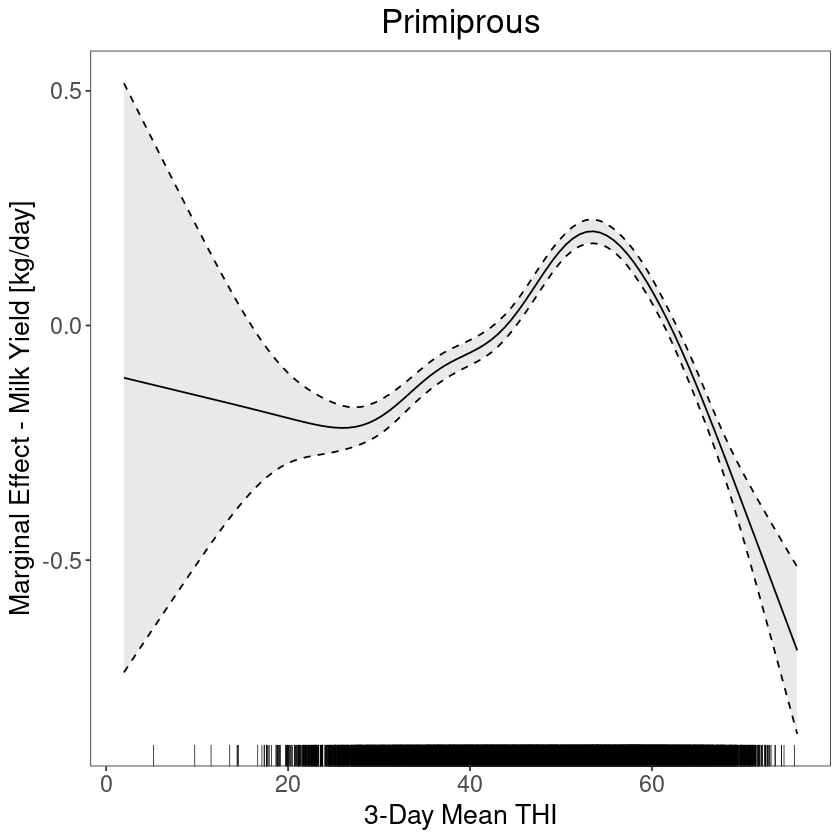

In [9]:
plot(sm(b, 2)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug() +
  labs(title = "Primiprous", 
       x = "3-Day Mean THI", 
       y = "Marginal Effect - Milk Yield [kg/day]") +
theme(plot.title = element_text(hjust = 0.5, size = 20),  # Center title and increase size
        axis.title.x = element_text(size = 16),  # Increase X-axis label size
        axis.title.y = element_text(size = 16),  # Increase Y-axis label size
        axis.text = element_text(size = 14))
ggsave("ho_milk_before2010_marginal_thi_milk_primi.png", width = 6, height = 6)

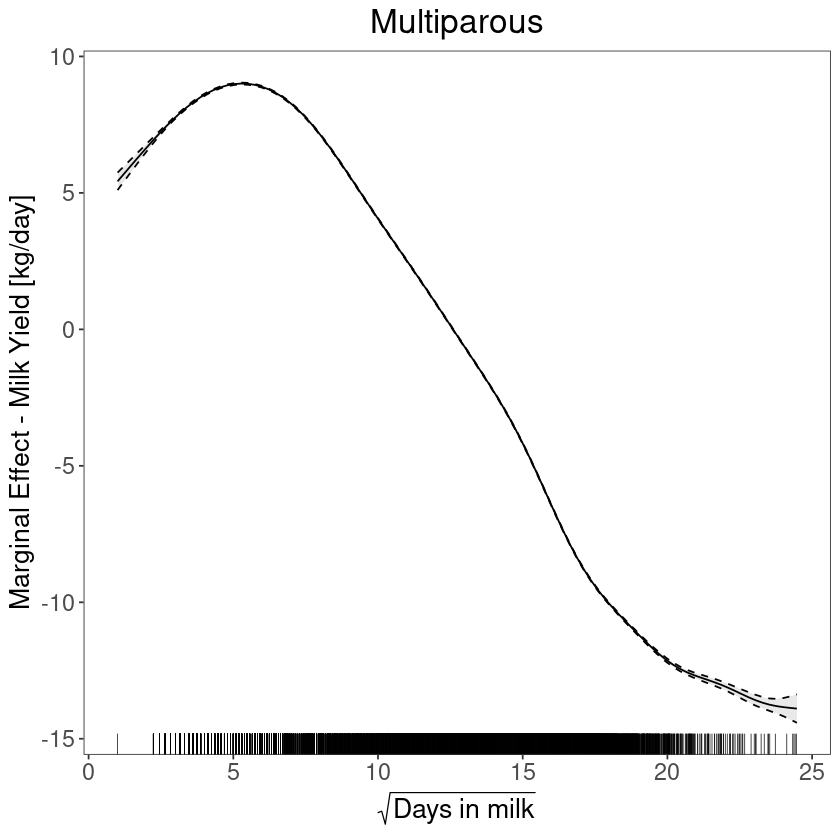

In [10]:
plot(sm(b, 3)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug() +
  labs(title = "Multiparous", 
       x = expression(sqrt("Days in milk")), 
       y = "Marginal Effect - Milk Yield [kg/day]") +
theme(plot.title = element_text(hjust = 0.5, size = 20),  # Center title and increase size
        axis.title.x = element_text(size = 16),  # Increase X-axis label size
        axis.title.y = element_text(size = 16),  # Increase Y-axis label size
        axis.text = element_text(size = 14))
ggsave("ho_milk_before2010_marginal_dim_milk_multi.png", width = 6, height = 6)

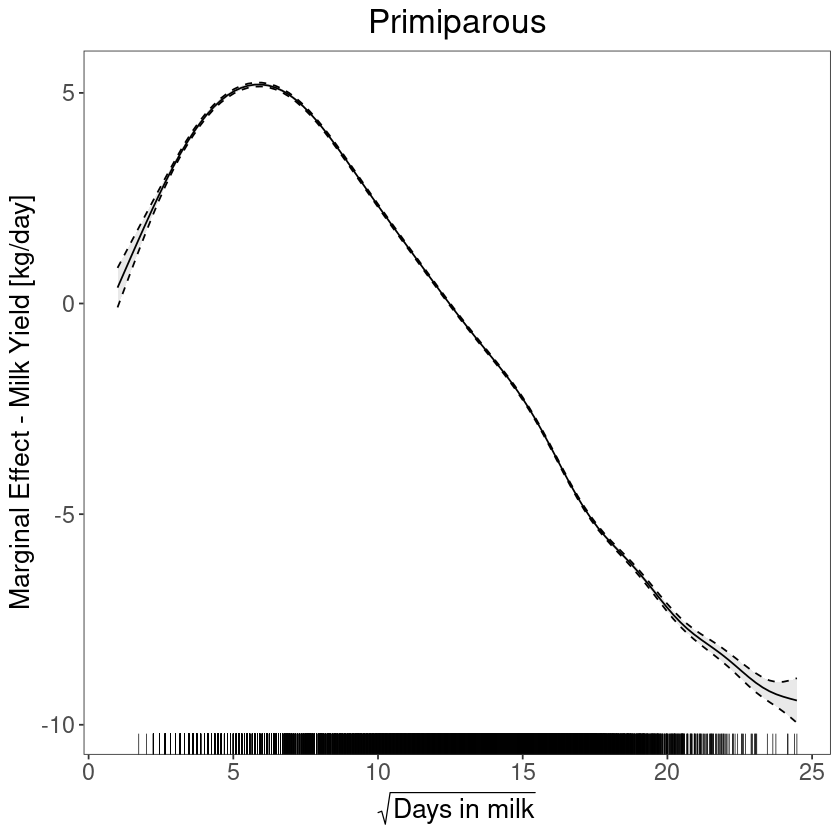

In [11]:
plot(sm(b, 4)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug() +
  labs(title = "Primiparous", 
       x = expression(sqrt("Days in milk")), 
       y = "Marginal Effect - Milk Yield [kg/day]") +
theme(plot.title = element_text(hjust = 0.5, size = 20),  # Center title and increase size
        axis.title.x = element_text(size = 16),  # Increase X-axis label size
        axis.title.y = element_text(size = 16),  # Increase Y-axis label size
        axis.text = element_text(size = 14))
ggsave("ho_milk_before2010_marginal_dim_milk_primi.png", width = 6, height = 6)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




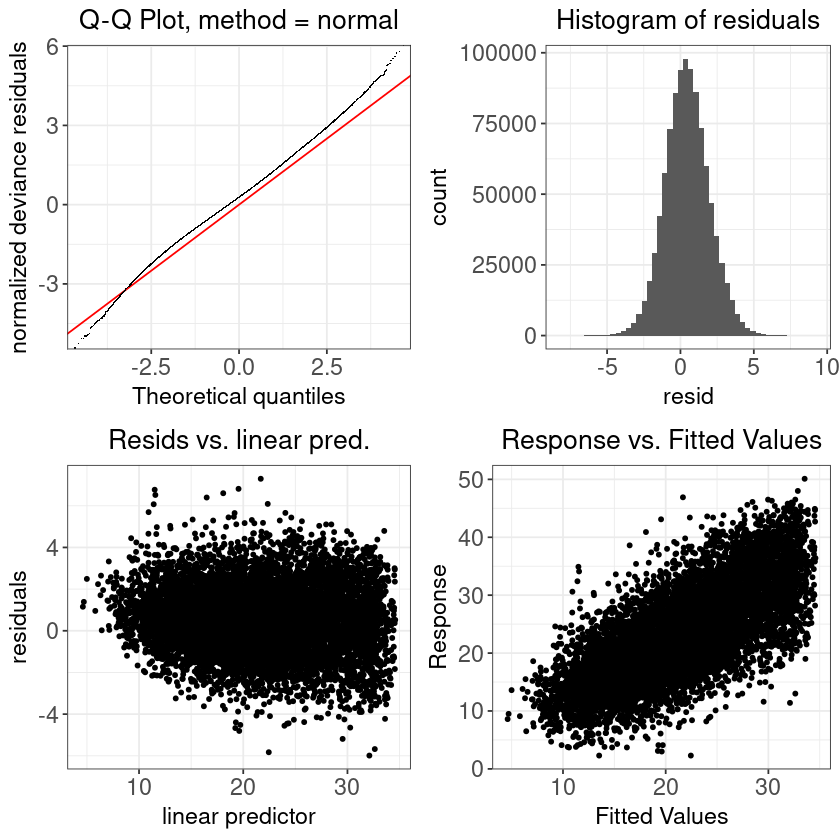

In [12]:
check_plot <- check(b,
      type = "tnormal",
      a.qq = list( 
          a.cipoly = list(fill = "light blue")), 
          a.respoi = list(size = 1), 
          a.hist = list(bins = 50))
library(gridExtra)
print.checkGam <- function(x, lay = NULL, ...)
{
  if( is.null(lay) ){
    lay <- matrix(c(1, 2,  
                    3, 4), 2, 2)
  } 
  
  x <- lapply(x, function(.inp) .inp+theme_bw() +
theme(plot.title = element_text(hjust = 0.5, size = 16),  # Center title and increase size
        axis.title.x = element_text(size = 14),  # Increase X-axis label size
        axis.title.y = element_text(size = 14),  # Increase Y-axis label size
        axis.text = element_text(size = 14)))
  
  out <- grid.arrange(grobs=x, layout_matrix=lay, ...)
  
  #return( invisible(out) )
}
ggsave("ho_milk_before2010_diagnostics.png", plot=print.checkGam(check_plot), width = 7, height = 7)